# Projet Séminaire Modélisation Statistique

Importations nécessaires:

In [46]:
library(readr)
library(readxl)
library(tidyr)
library(dplyr)
library(stringr)
library(purrr)

In [2]:
#Set directory
setwd("C:/Users/Pauline/Documents/Github/Seminaire-Modelisation-Stat/Data")

### Ouverture et nettoyage des données

In [92]:
data_test <- read.csv("data_test.csv")
data_train <- read.csv("data_train.csv")
benchmark <- read.csv("benchmark.csv")

In [93]:
#Drop NAs
data_test <- data_test %>% drop_na()
data_train <- data_train %>% drop_na()
benchmark <- benchmark %>% drop_na()

On crée une colonne pour l'année, le mois, le jour, le jour de la semaine et l'heure.

In [94]:
data_train = data_train %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

data_test = data_test %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

benchmark = benchmark %>% 
            separate(DateTime, c("Date", "Time"), sep = " ", remove = TRUE) %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

In [95]:
data_train$Date = as.Date(data_train$Date, format = "%Y-%m-%d")
data_train["Weekday"] =  weekdays(data_train$Date)

data_test$Date = as.Date(data_test$Date, format = "%Y-%m-%d")
data_test["Weekday"] =  weekdays(data_test$Date)

benchmark$Date = as.Date(benchmark$Date, format = "%Y-%m-%d")
benchmark["Weekday"] =  weekdays(benchmark$Date)

Ajout d'une variable jour ferié.

In [96]:
jours_feries <- read.csv("jours_feries_metropole.csv")

In [97]:
jours_feries$date = as.Date(jours_feries$date, format = "%Y-%m-%d")
jours_feries = jours_feries %>%
    filter(format(date, format = "%Y") > 2011) %>%
    select (-zone,-annee)

In [98]:
jours_feries = rename(jours_feries,Date=date)

In [99]:
data_train = left_join(data_train,jours_feries)

data_test = left_join(data_test,jours_feries)

benchmark = left_join(benchmark,jours_feries)

Joining, by = "Date"
Joining, by = "Date"
Joining, by = "Date"


In [100]:
data_train$nom_jour_ferie[is.character(data_train$nom_jour_ferie) & is.na(data_train$nom_jour_ferie)] = 0
data_train = rename(data_train, jour_ferie = nom_jour_ferie)

data_test$nom_jour_ferie[is.character(data_test$nom_jour_ferie) & is.na(data_test$nom_jour_ferie)] = 0
data_test = rename(data_test, jour_ferie = nom_jour_ferie)

benchmark$nom_jour_ferie[is.character(benchmark$nom_jour_ferie) & is.na(benchmark$nom_jour_ferie)] = 0
benchmark = rename(benchmark, jour_ferie = nom_jour_ferie)

##### Ajout vacances scolaires

In [101]:
holidays <- read.csv("data_holidays.csv")

In [102]:
holidays$date = as.Date(holidays$date, format = "%Y-%m-%d")
holidays = holidays %>%
    filter(format(date, format = "%Y") > 2011) %>%
    select (-nom_vacances)

In [103]:
holidays = rename(holidays,Date=date)
holidays = rename(holidays,Holidays_A=vacances_zone_a)
holidays = rename(holidays,Holidays_B=vacances_zone_b)
holidays = rename(holidays,Holidays_C=vacances_zone_c)

In [104]:
data_train = left_join(data_train,holidays,"Date")

data_test = left_join(data_test,holidays,"Date")

benchmark = left_join(benchmark,holidays,"Date")

In [105]:
data_train$Holidays_A <- as.integer(as.logical(data_train$Holidays_A))
data_train$Holidays_B <- as.integer(as.logical(data_train$Holidays_B))
data_train$Holidays_C <- as.integer(as.logical(data_train$Holidays_C))

data_test$Holidays_A <- as.integer(as.logical(data_test$Holidays_A))
data_test$Holidays_B <- as.integer(as.logical(data_test$Holidays_B))
data_test$Holidays_C <- as.integer(as.logical(data_test$Holidays_C))

benchmark$Holidays_A <- as.integer(as.logical(benchmark$Holidays_A))
benchmark$Holidays_B <- as.integer(as.logical(benchmark$Holidays_B))
benchmark$Holidays_C <- as.integer(as.logical(benchmark$Holidays_C))

In [106]:
data_train$Holidays <- 0
data_train$Holidays[data_train$Holidays_A==1 | data_train$Holidays_B==1 | data_train$Holidays_B==1] <- 1

data_test$Holidays <- 0
data_test$Holidays[data_test$Holidays_A==1 | data_test$Holidays_B==1 | data_test$Holidays_B==1] <- 1

benchmark$Holidays <- 0
benchmark$Holidays[benchmark$Holidays_A==1 | benchmark$Holidays_B==1 | benchmark$Holidays_B==1] <- 1

In [107]:
#Check
data_train
data_test
benchmark

Date,Year,Month,Day,Time,Consumption,Temperature,Nebulosity,Humidity,Weekday,jour_ferie,Holidays_A,Holidays_B,Holidays_C,Holidays
<date>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
2012-01-01,2012,01,01,00:00:00,58315,13.443860,87.50000,87.64912,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,03:00:00,52496,13.370175,76.35135,88.26786,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,06:00:00,45827,13.743103,78.10638,88.19298,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,09:00:00,45730,13.669643,81.27660,87.80000,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,12:00:00,50975,15.675439,80.00000,81.67857,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,15:00:00,49148,15.442857,83.37209,80.67857,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,18:00:00,54425,13.592727,86.32353,85.25455,dimanche,1er janvier,1,1,1,1
2012-01-01,2012,01,01,21:00:00,56054,12.868421,88.63636,87.61404,dimanche,1er janvier,1,1,1,1
2012-01-02,2012,01,02,00:00:00,55164,11.869091,87.61290,88.10909,lundi,0,1,1,1,1


Date,Year,Month,Day,Time,Temperature,Nebulosity,Humidity,Weekday,jour_ferie,Holidays_A,Holidays_B,Holidays_C,Holidays
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
2021-11-01,2021,11,01,00:00:00,14.87018,90.89286,86.57895,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,03:00:00,14.10833,91.33333,88.01667,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,06:00:00,13.86949,97.00000,87.74576,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,09:00:00,14.78983,88.22581,83.57627,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,12:00:00,16.45763,91.55172,72.67797,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,15:00:00,16.09831,86.20000,72.33898,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,18:00:00,13.85690,85.22222,80.24138,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,21:00:00,13.02542,85.43478,83.06780,lundi,Toussaint,1,1,1,1
2021-11-02,2021,11,02,00:00:00,12.78833,90.92857,84.75000,mardi,0,1,1,1,1


Date,Year,Month,Day,Time,Consumption,Weekday,jour_ferie,Holidays_A,Holidays_B,Holidays_C,Holidays
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>
2021-11-01,2021,11,01,00:00:00,53512.07,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,00:30:00,51018.66,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,01:00:00,48142.49,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,01:30:00,47526.87,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,02:00:00,46981.54,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,02:30:00,46584.09,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,03:00:00,45199.19,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,03:30:00,44469.71,lundi,Toussaint,1,1,1,1
2021-11-01,2021,11,01,04:00:00,43840.57,lundi,Toussaint,1,1,1,1


### Statistiques Descriptives

In [19]:
library(ggplot2)
library(ggthemes)
library(repr)

Warning message:
"le package 'repr' a été compilé avec la version R 4.1.3"


In [20]:
summary(data_train)

      Date                Year              Month               Day           
 Min.   :2012-01-01   Length:26286       Length:26286       Length:26286      
 1st Qu.:2014-04-01   Class :character   Class :character   Class :character  
 Median :2016-06-30   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2016-07-01                                                           
 3rd Qu.:2018-10-01                                                           
 Max.   :2020-12-31                                                           
     Time            Consumption     Temperature       Nebulosity     
 Length:26286       Min.   :29482   Min.   :-0.366   Min.   :  7.667  
 Class :character   1st Qu.:44984   1st Qu.:11.207   1st Qu.: 68.000  
 Mode  :character   Median :52366   Median :14.523   Median : 80.588  
                    Mean   :54075   Mean   :14.876   Mean   : 76.117  
                    3rd Qu.:62286   3rd Qu.:18.203   3rd Qu.: 88.409  
                    M

##### Etude de la Température

`geom_smooth()` using formula 'y ~ x'



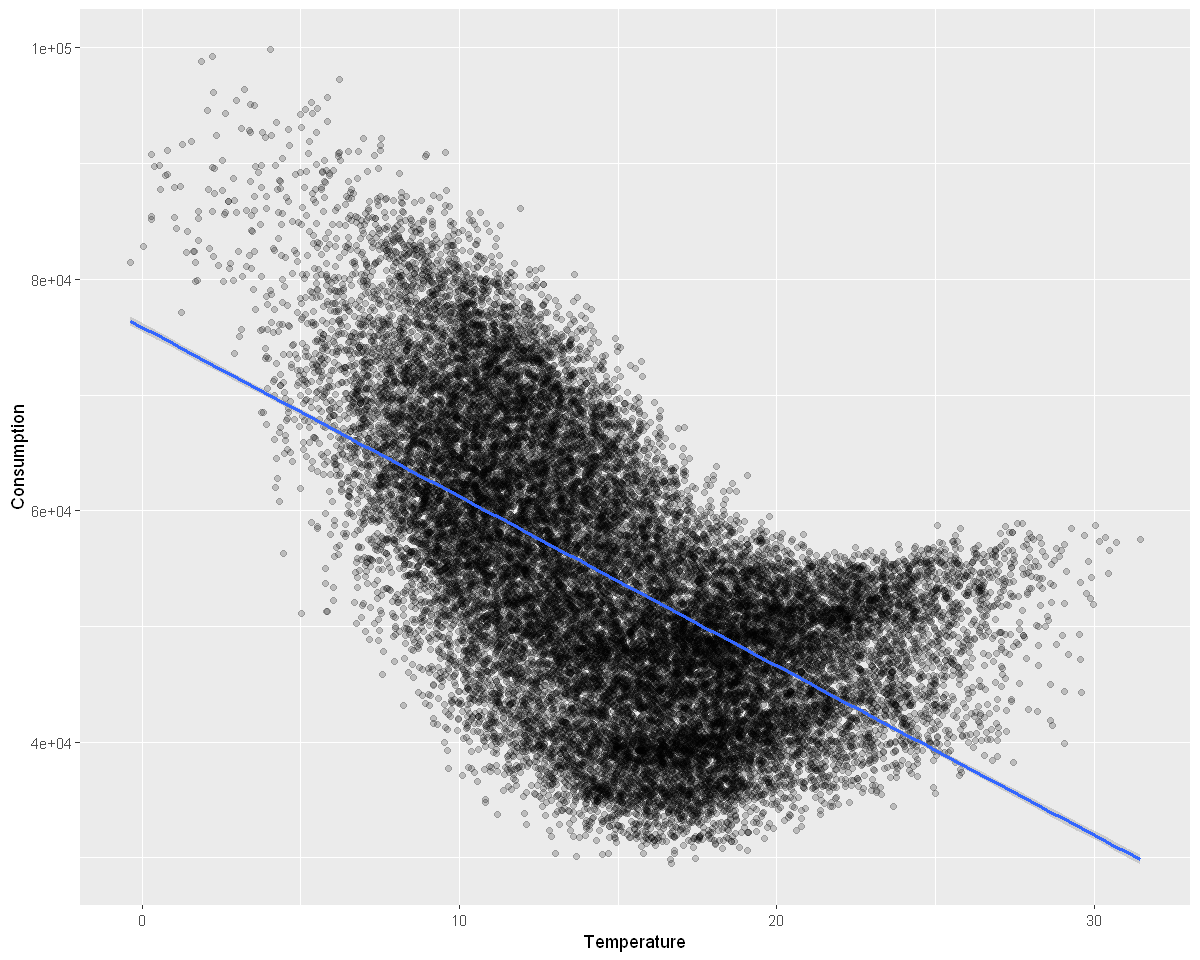

In [21]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train, aes(x = Temperature, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Relation clairement négative entre la Température et la Consommation

In [139]:
#Normalisation des données
data_train$Temperature_normalized <- (data_train$Temperature - mean(data_train$Temperature)) / sd(data_train$Temperature)
data_train$Consumption_normalized <- (data_train$Consumption - mean(data_train$Consumption)) / sd(data_train$Consumption)
data_train$Nebulosity_normalized <- (data_train$Nebulosity - mean(data_train$Nebulosity)) / sd(data_train$Nebulosity)
data_train$Humidity_normalized <- (data_train$Humidity - mean(data_train$Humidity)) / sd(data_train$Humidity)

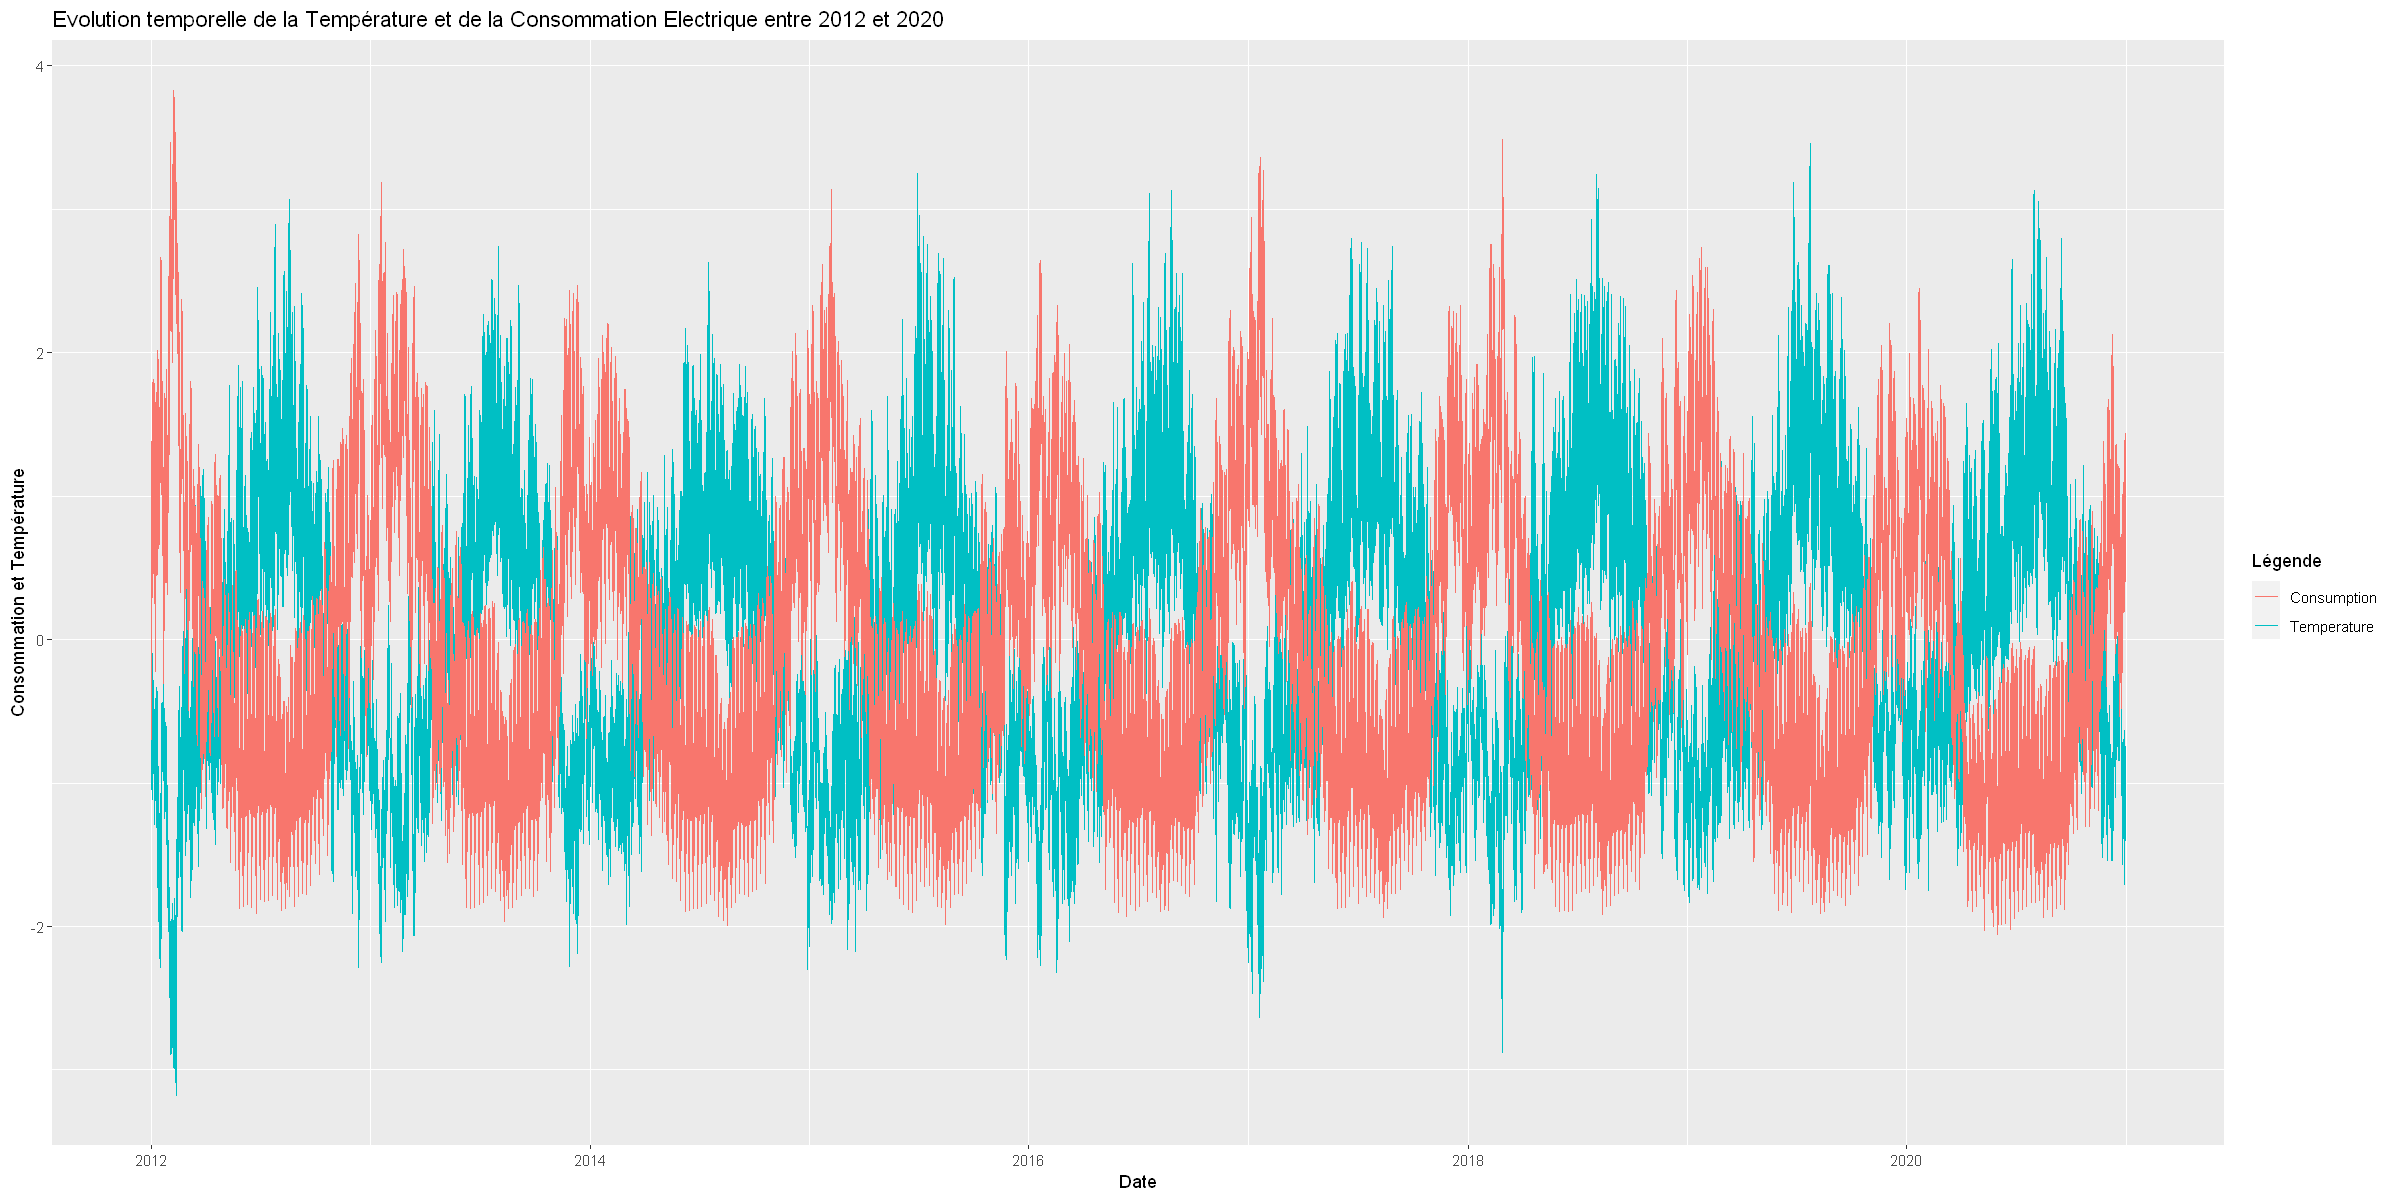

In [23]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la Température et de la Consommation Electrique entre 2012 et 2020") +
    ylab("Consommation et Température")

In [142]:
data_train_2012 <- subset(data_train, Year == 2012)

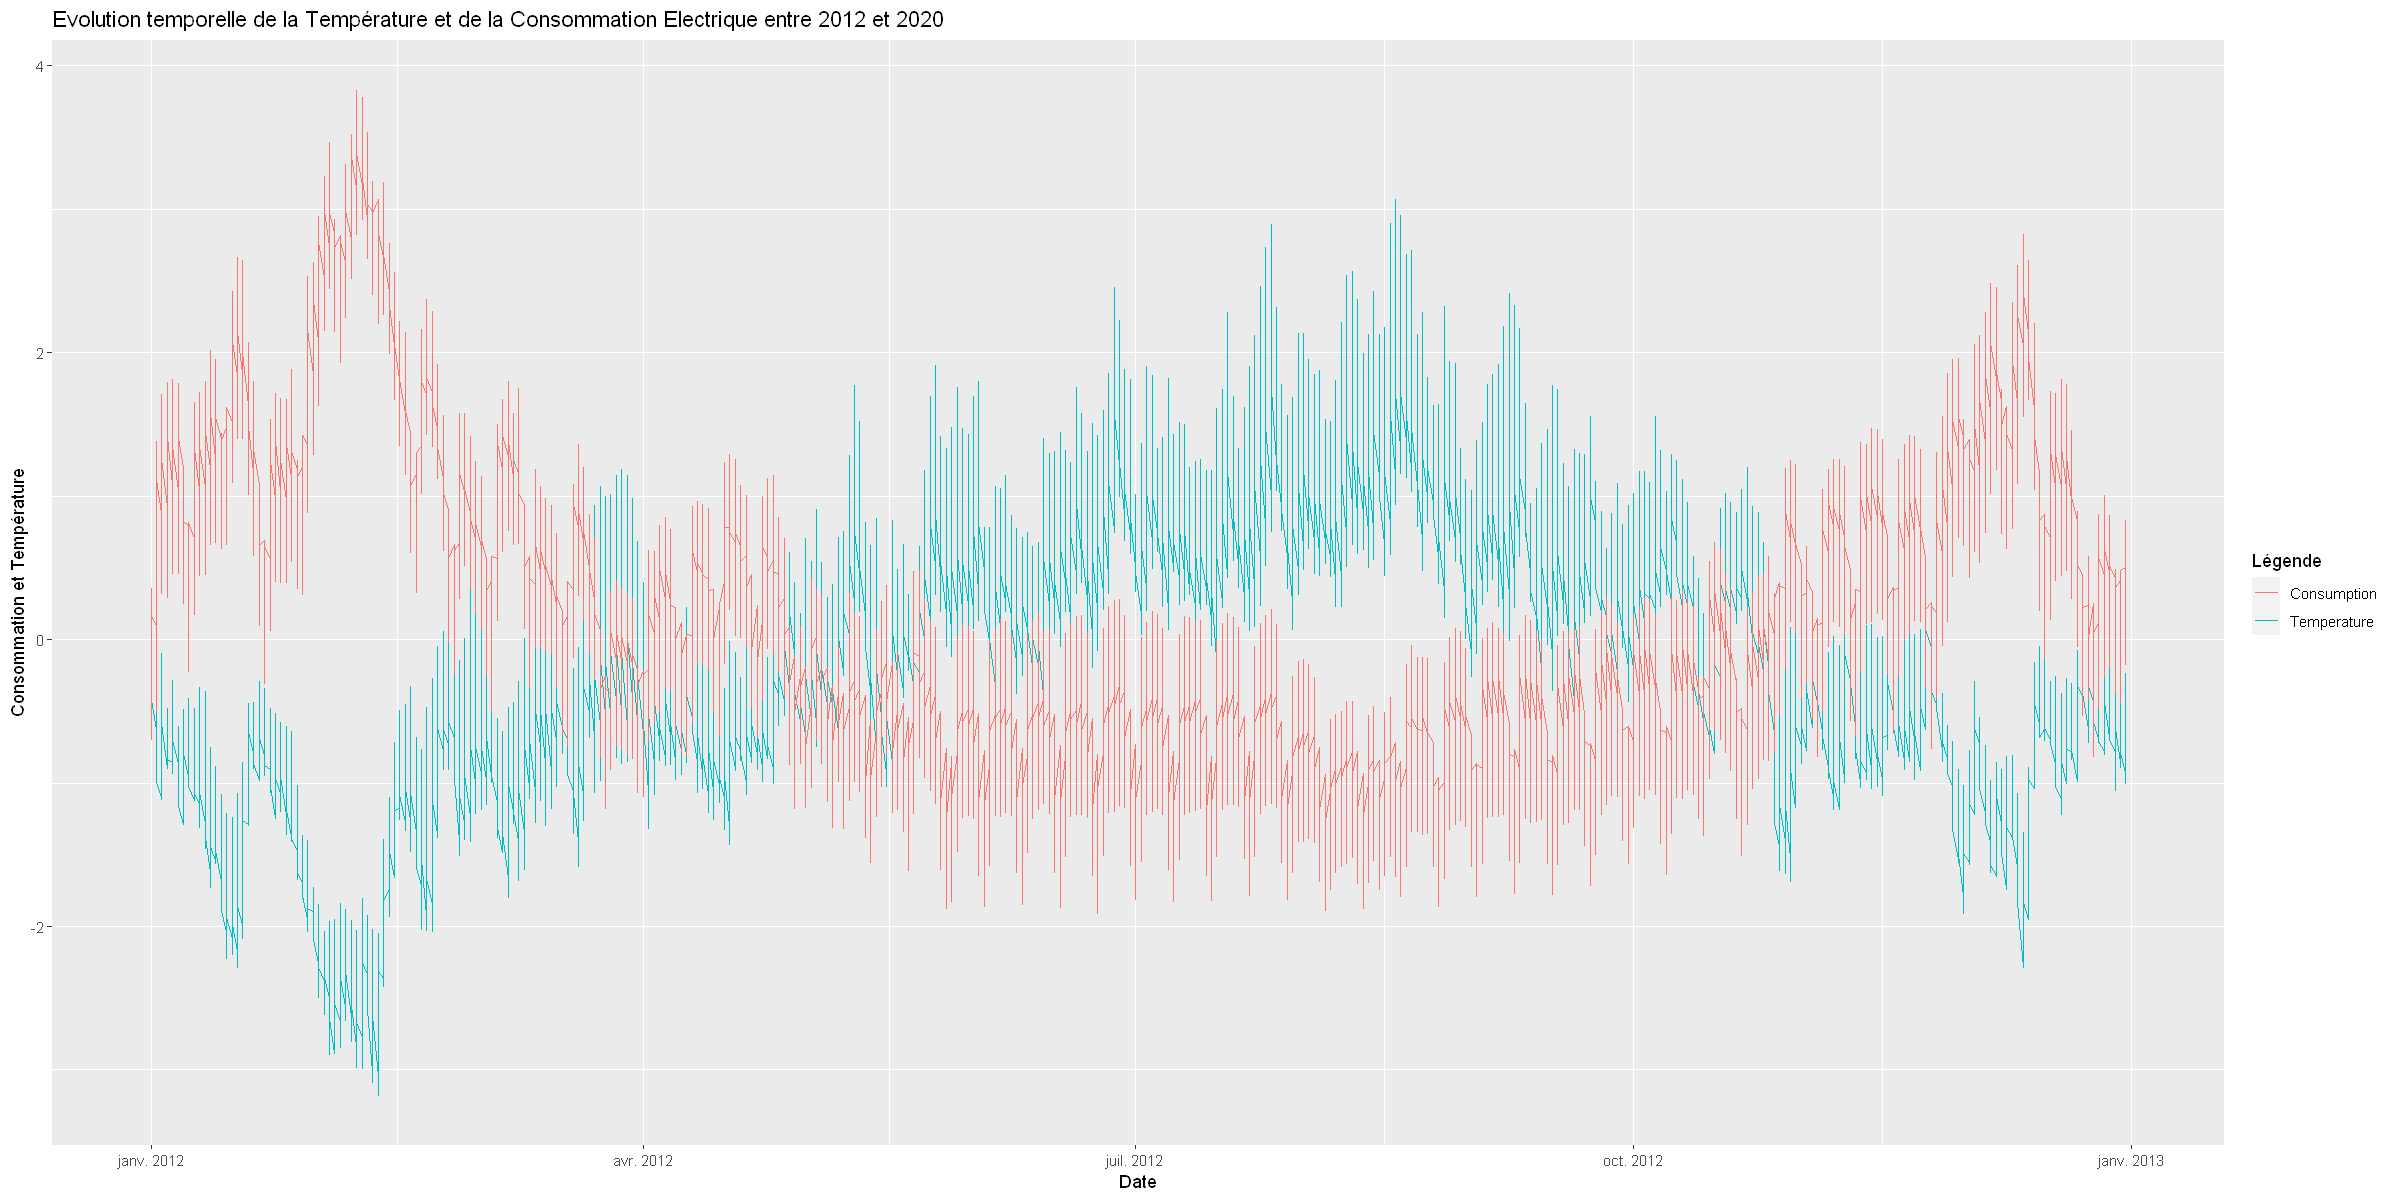

In [25]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_2012, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle de la Température et de la Consommation Electrique entre 2012") +
    ylab("Consommation et Température")

In [124]:
#Construction d'une base annuelle "type"
data_train_type <- data_train %>%
   group_by(Month, Day, Time) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

In [130]:
data_train_type$Date = paste(data_train_type$Month, data_train_type$Day, sep="-")
data_train_type$Date = as.Date(data_train_type$Date, format = "%m-%d")
data_train_type <- data_train_type %>% select(Date, everything())
data_train_type <- data_train_type %>% drop_na()

In [144]:
data_train_type$Temperature_normalized <- (data_train_type$Temperature - mean(data_train_type$Temperature)) / sd(data_train_type$Temperature)
data_train_type$Consumption_normalized <- (data_train_type$Consumption - mean(data_train_type$Consumption)) / sd(data_train_type$Consumption)
data_train_type$Nebulosity_normalized <- (data_train_type$Nebulosity - mean(data_train_type$Nebulosity)) / sd(data_train_type$Nebulosity)
data_train_type$Humidity_normalized <- (data_train_type$Humidity - mean(data_train_type$Humidity)) / sd(data_train_type$Humidity)

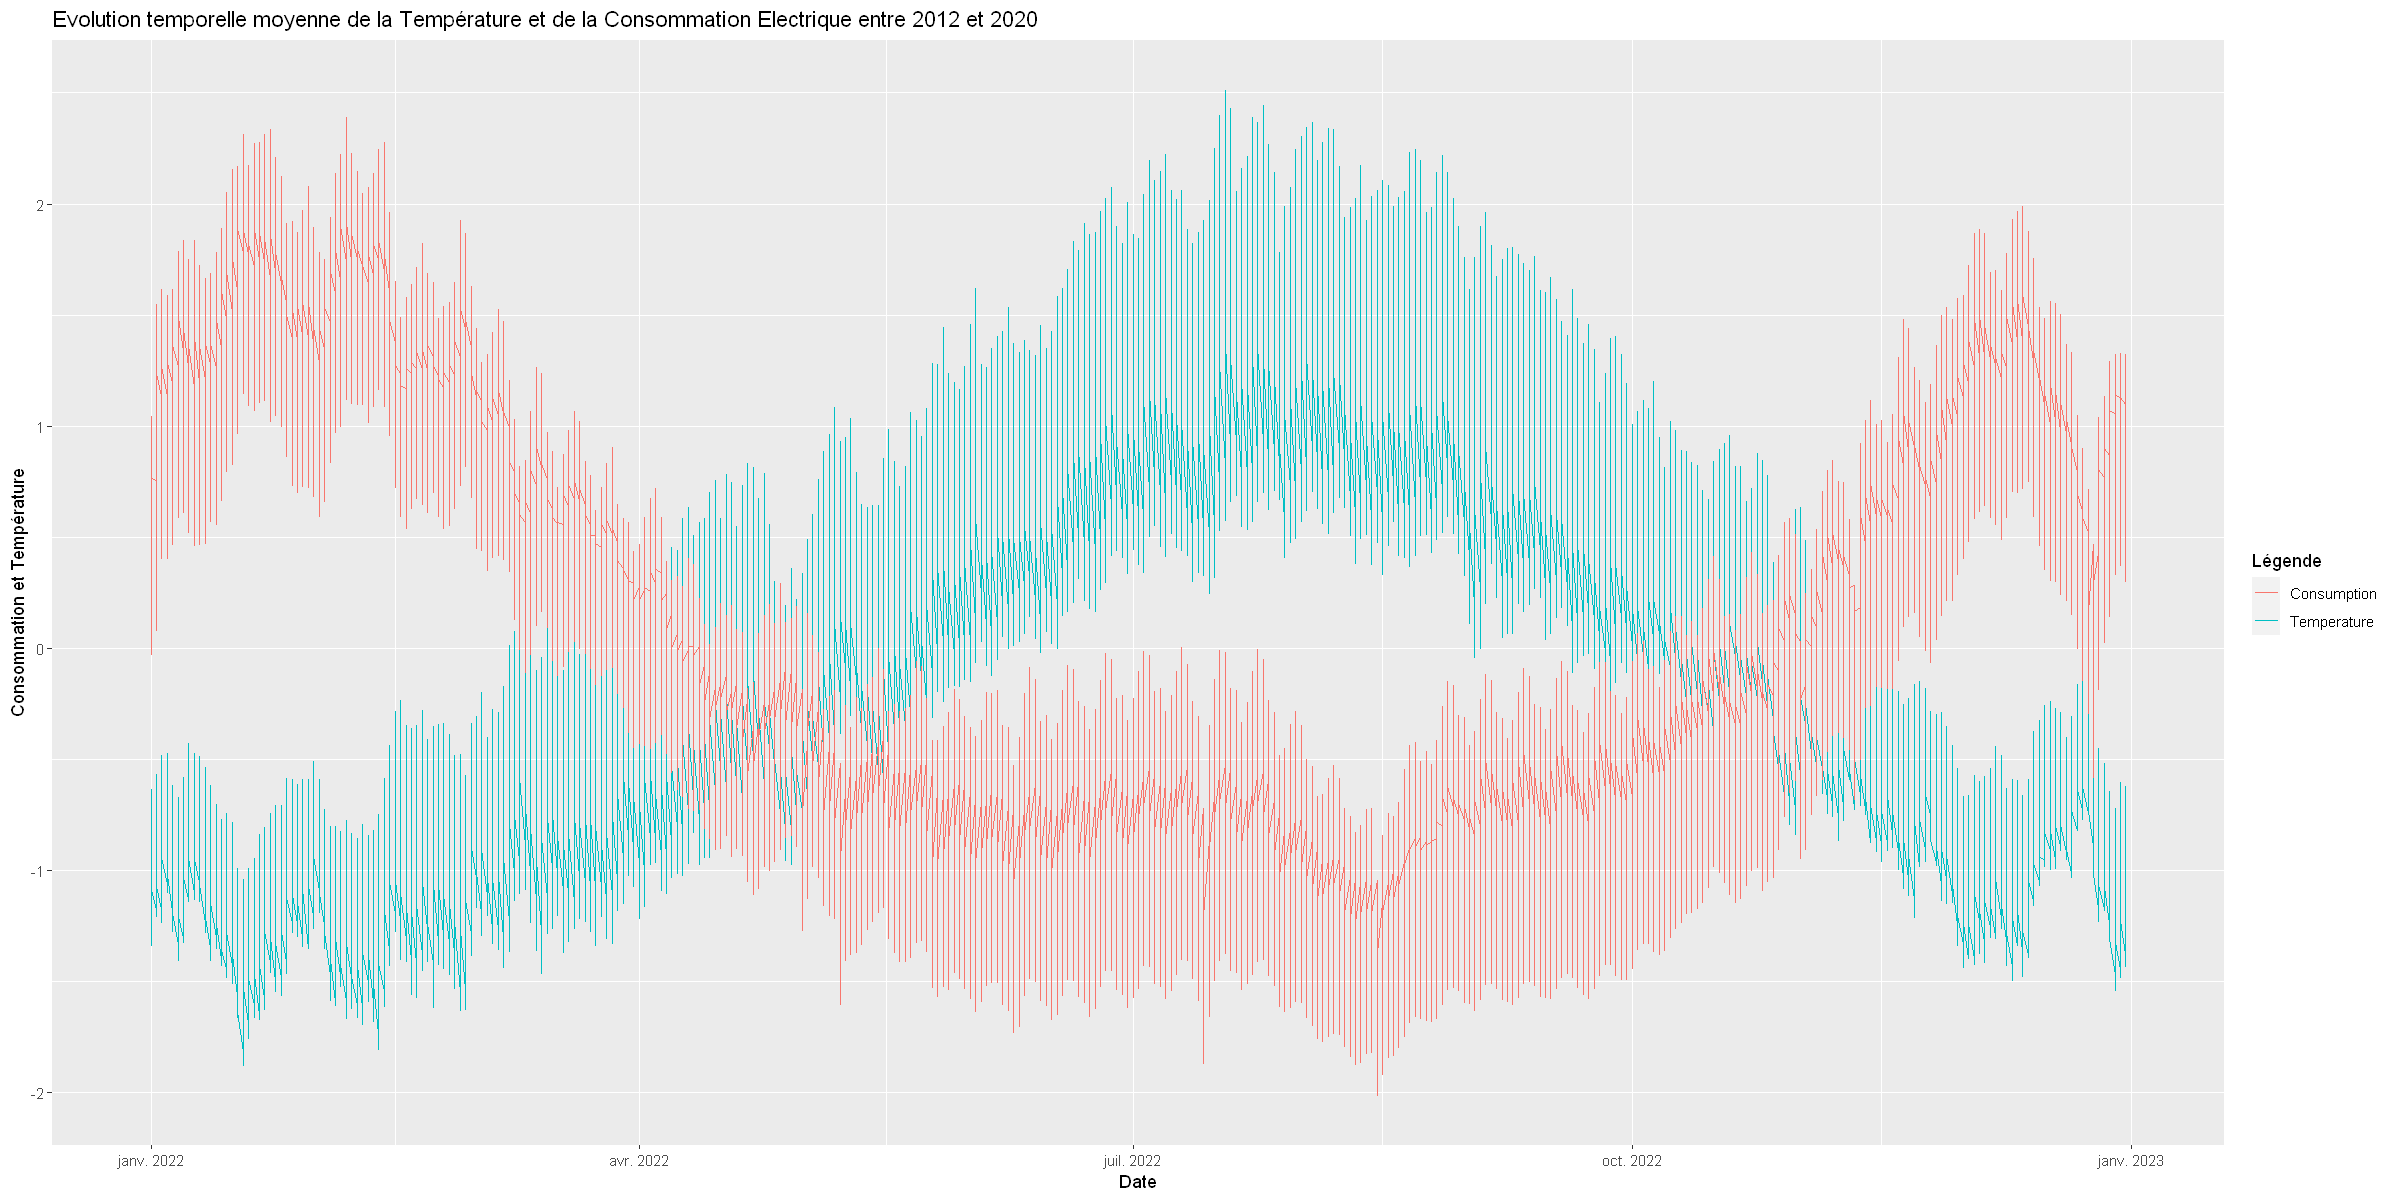

In [132]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_type, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Température et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Température")

In [134]:
data_train_type_notime <- data_train_type %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

In [146]:
data_train_type_notime$Temperature_normalized <- (data_train_type_notime$Temperature - mean(data_train_type_notime$Temperature)) / sd(data_train_type_notime$Temperature)
data_train_type_notime$Consumption_normalized <- (data_train_type_notime$Consumption - mean(data_train_type_notime$Consumption)) / sd(data_train_type_notime$Consumption)
data_train_type_notime$Nebulosity_normalized <- (data_train_type_notime$Nebulosity - mean(data_train_type_notime$Nebulosity)) / sd(data_train_type_notime$Nebulosity)
data_train_type_notime$Humidity_normalized <- (data_train_type_notime$Humidity - mean(data_train_type_notime$Humidity)) / sd(data_train_type_notime$Humidity)

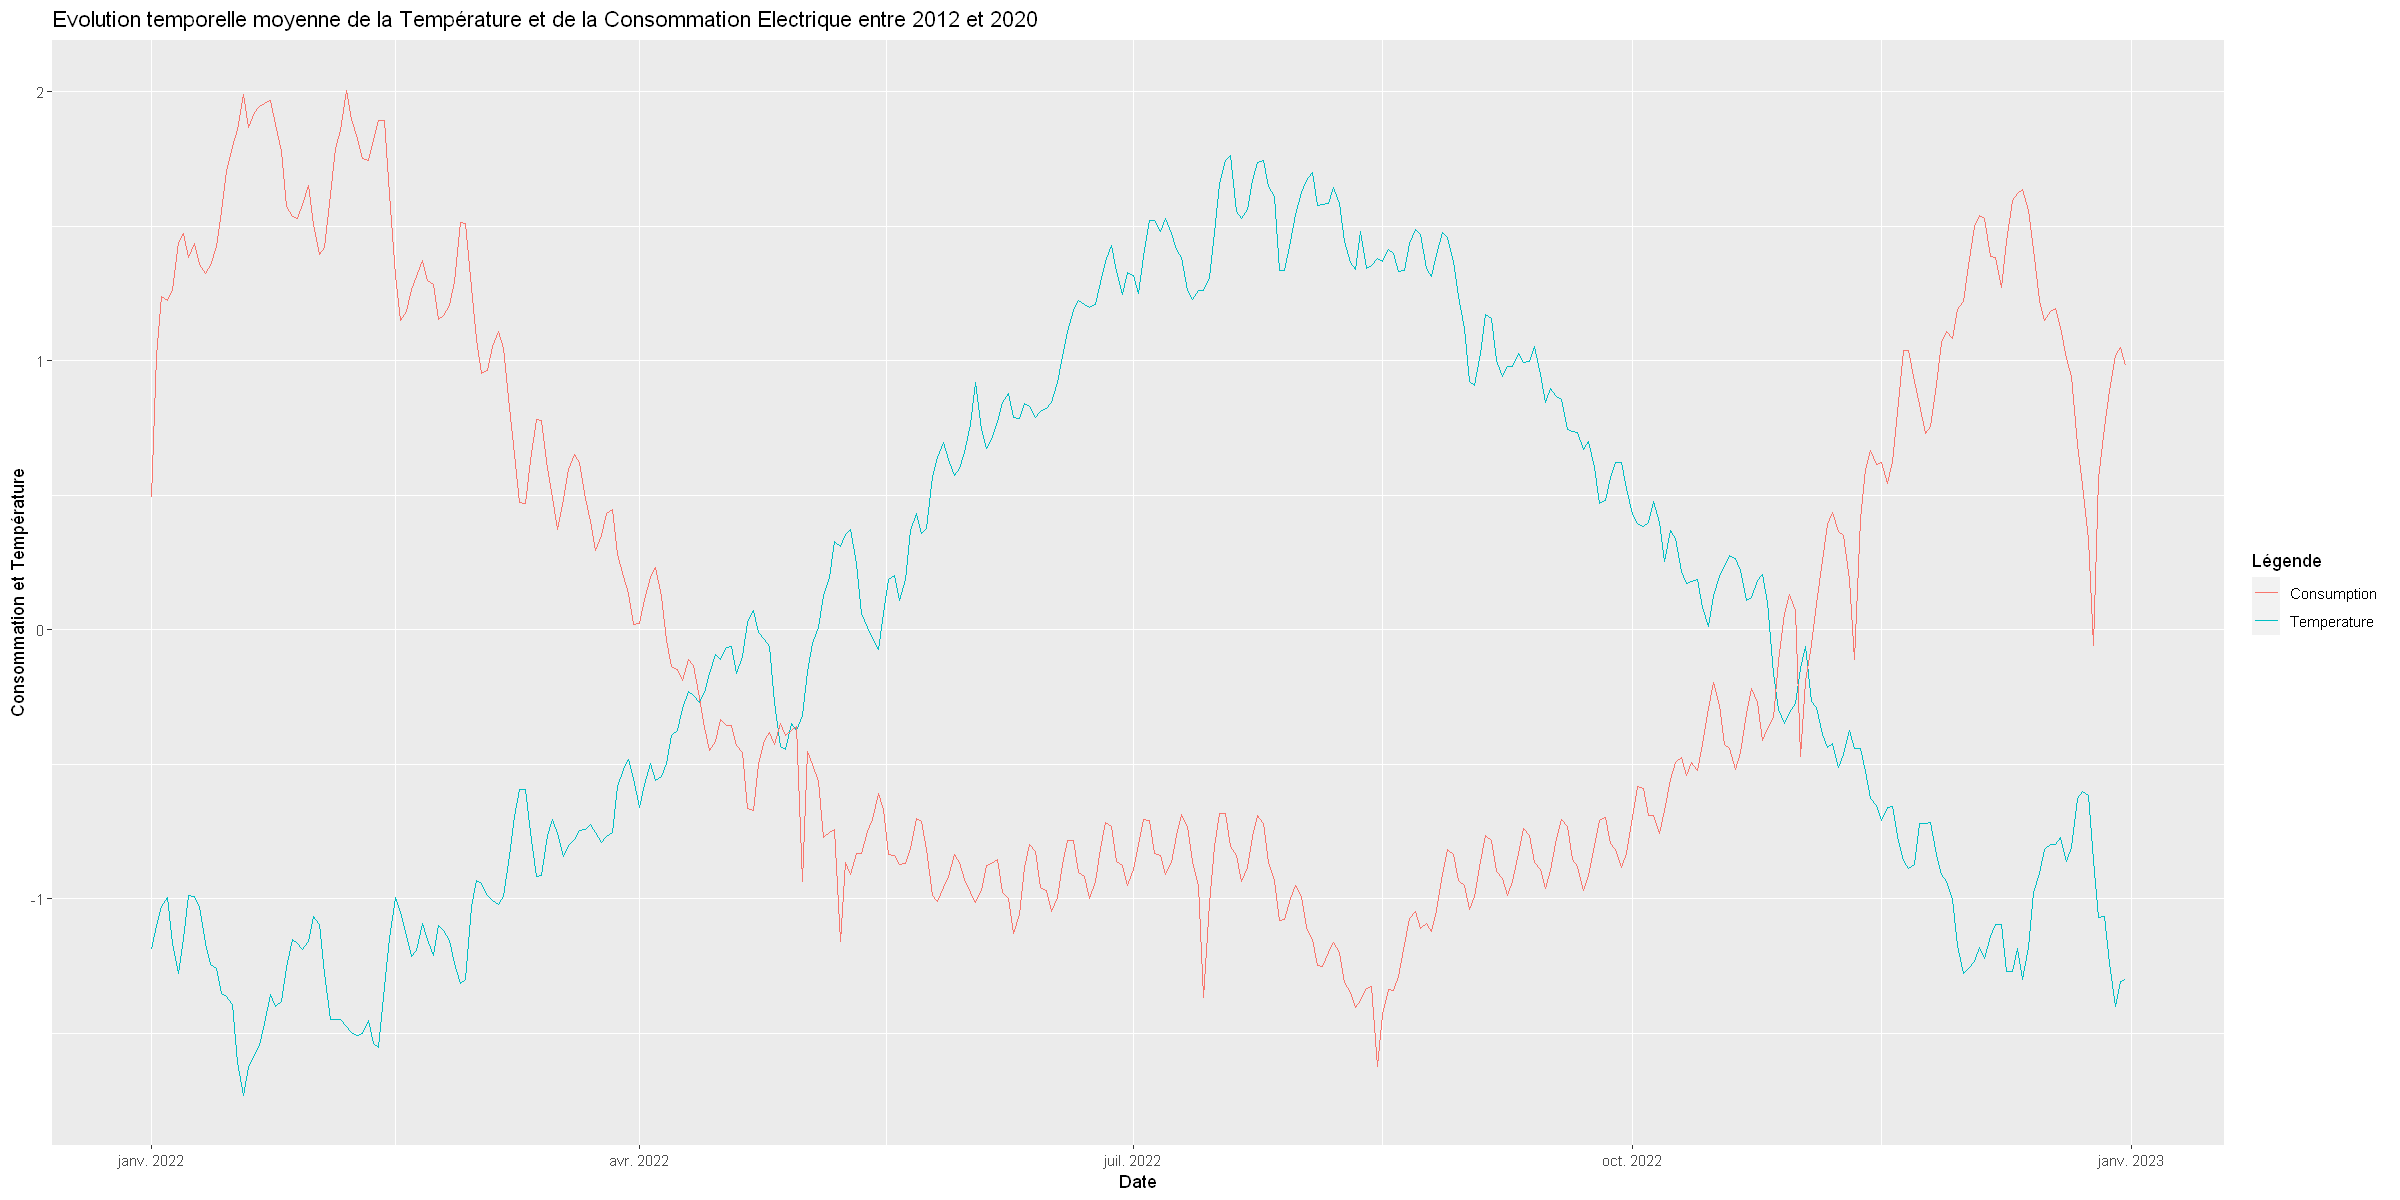

In [137]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_type_notime, aes(x=Date, y=Temperature_normalized, group = 1, color = 'Temperature')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consumption')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Température et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Température")

##### Etude de la Nébulosité 

`geom_smooth()` using formula 'y ~ x'



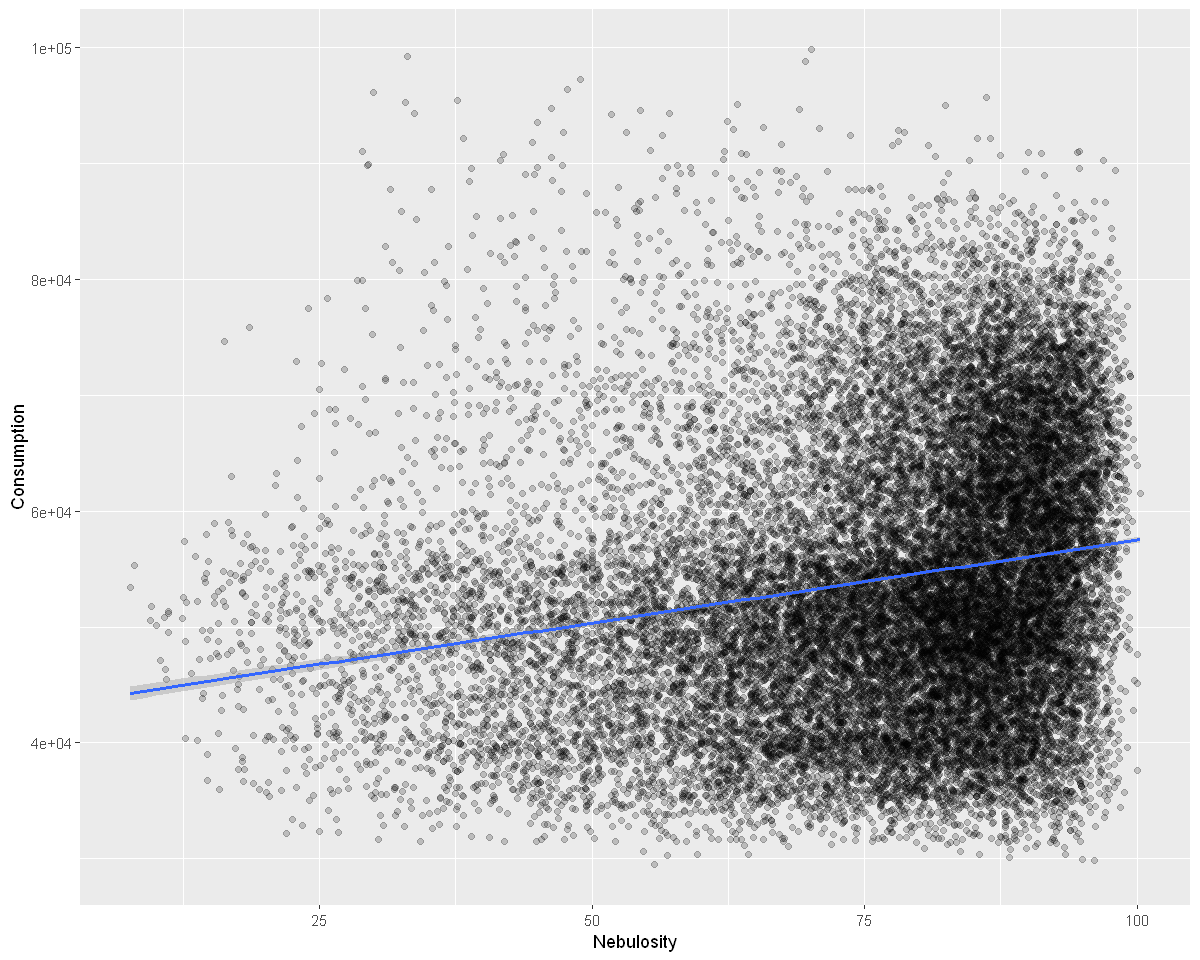

In [138]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train, aes(x = Nebulosity, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Relation positive

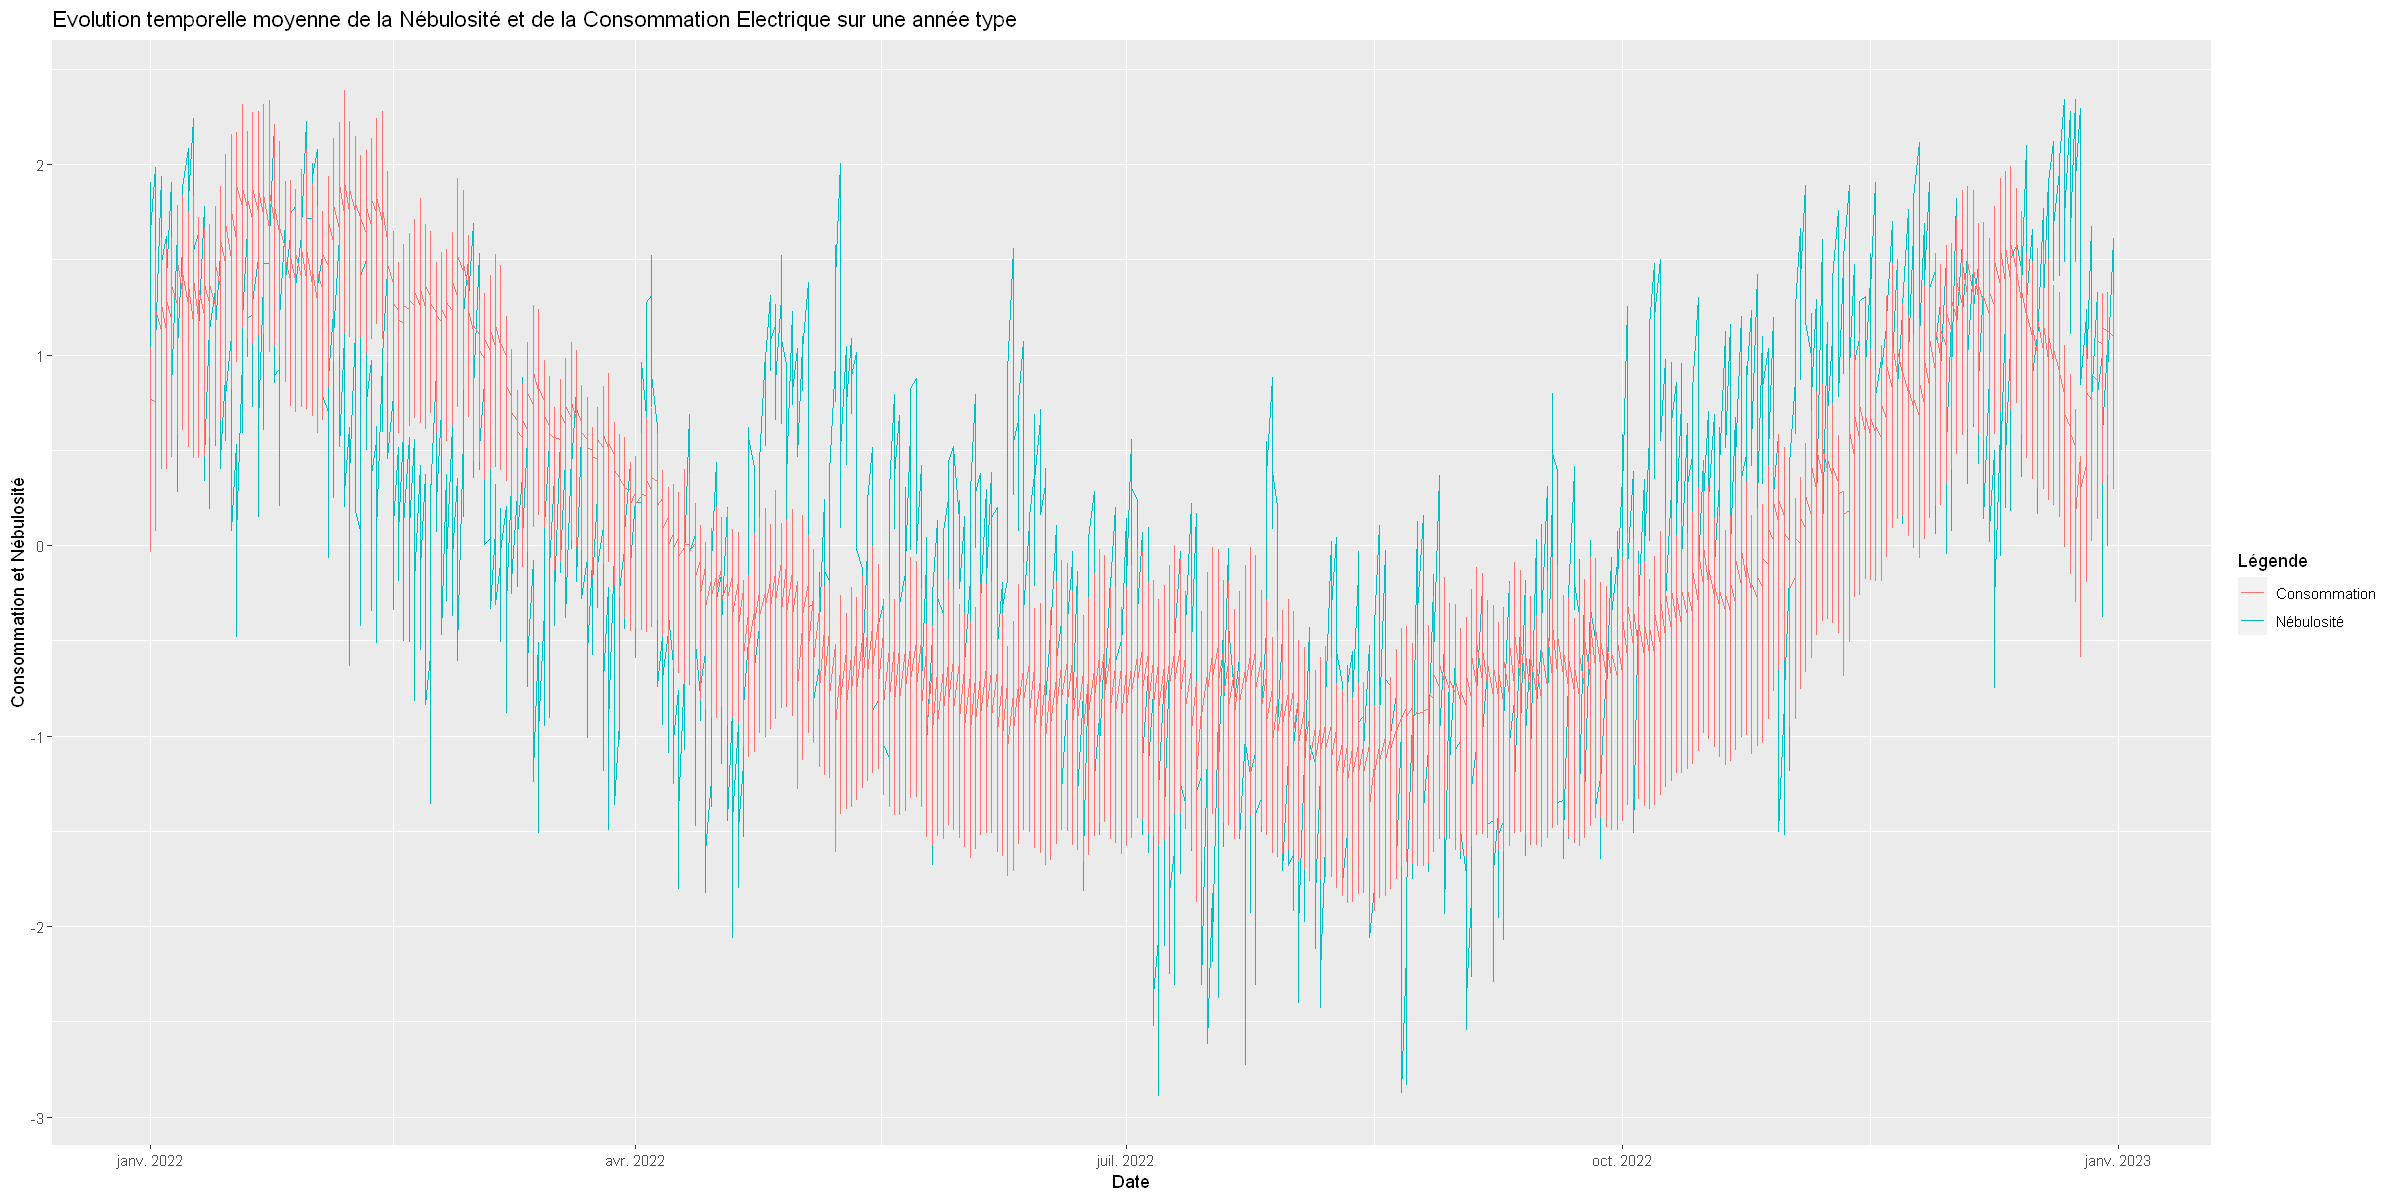

In [145]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_type, aes(x=Date, y=Nebulosity_normalized, group = 1, color = 'Nébulosité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Nébulosité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Nébulosité")

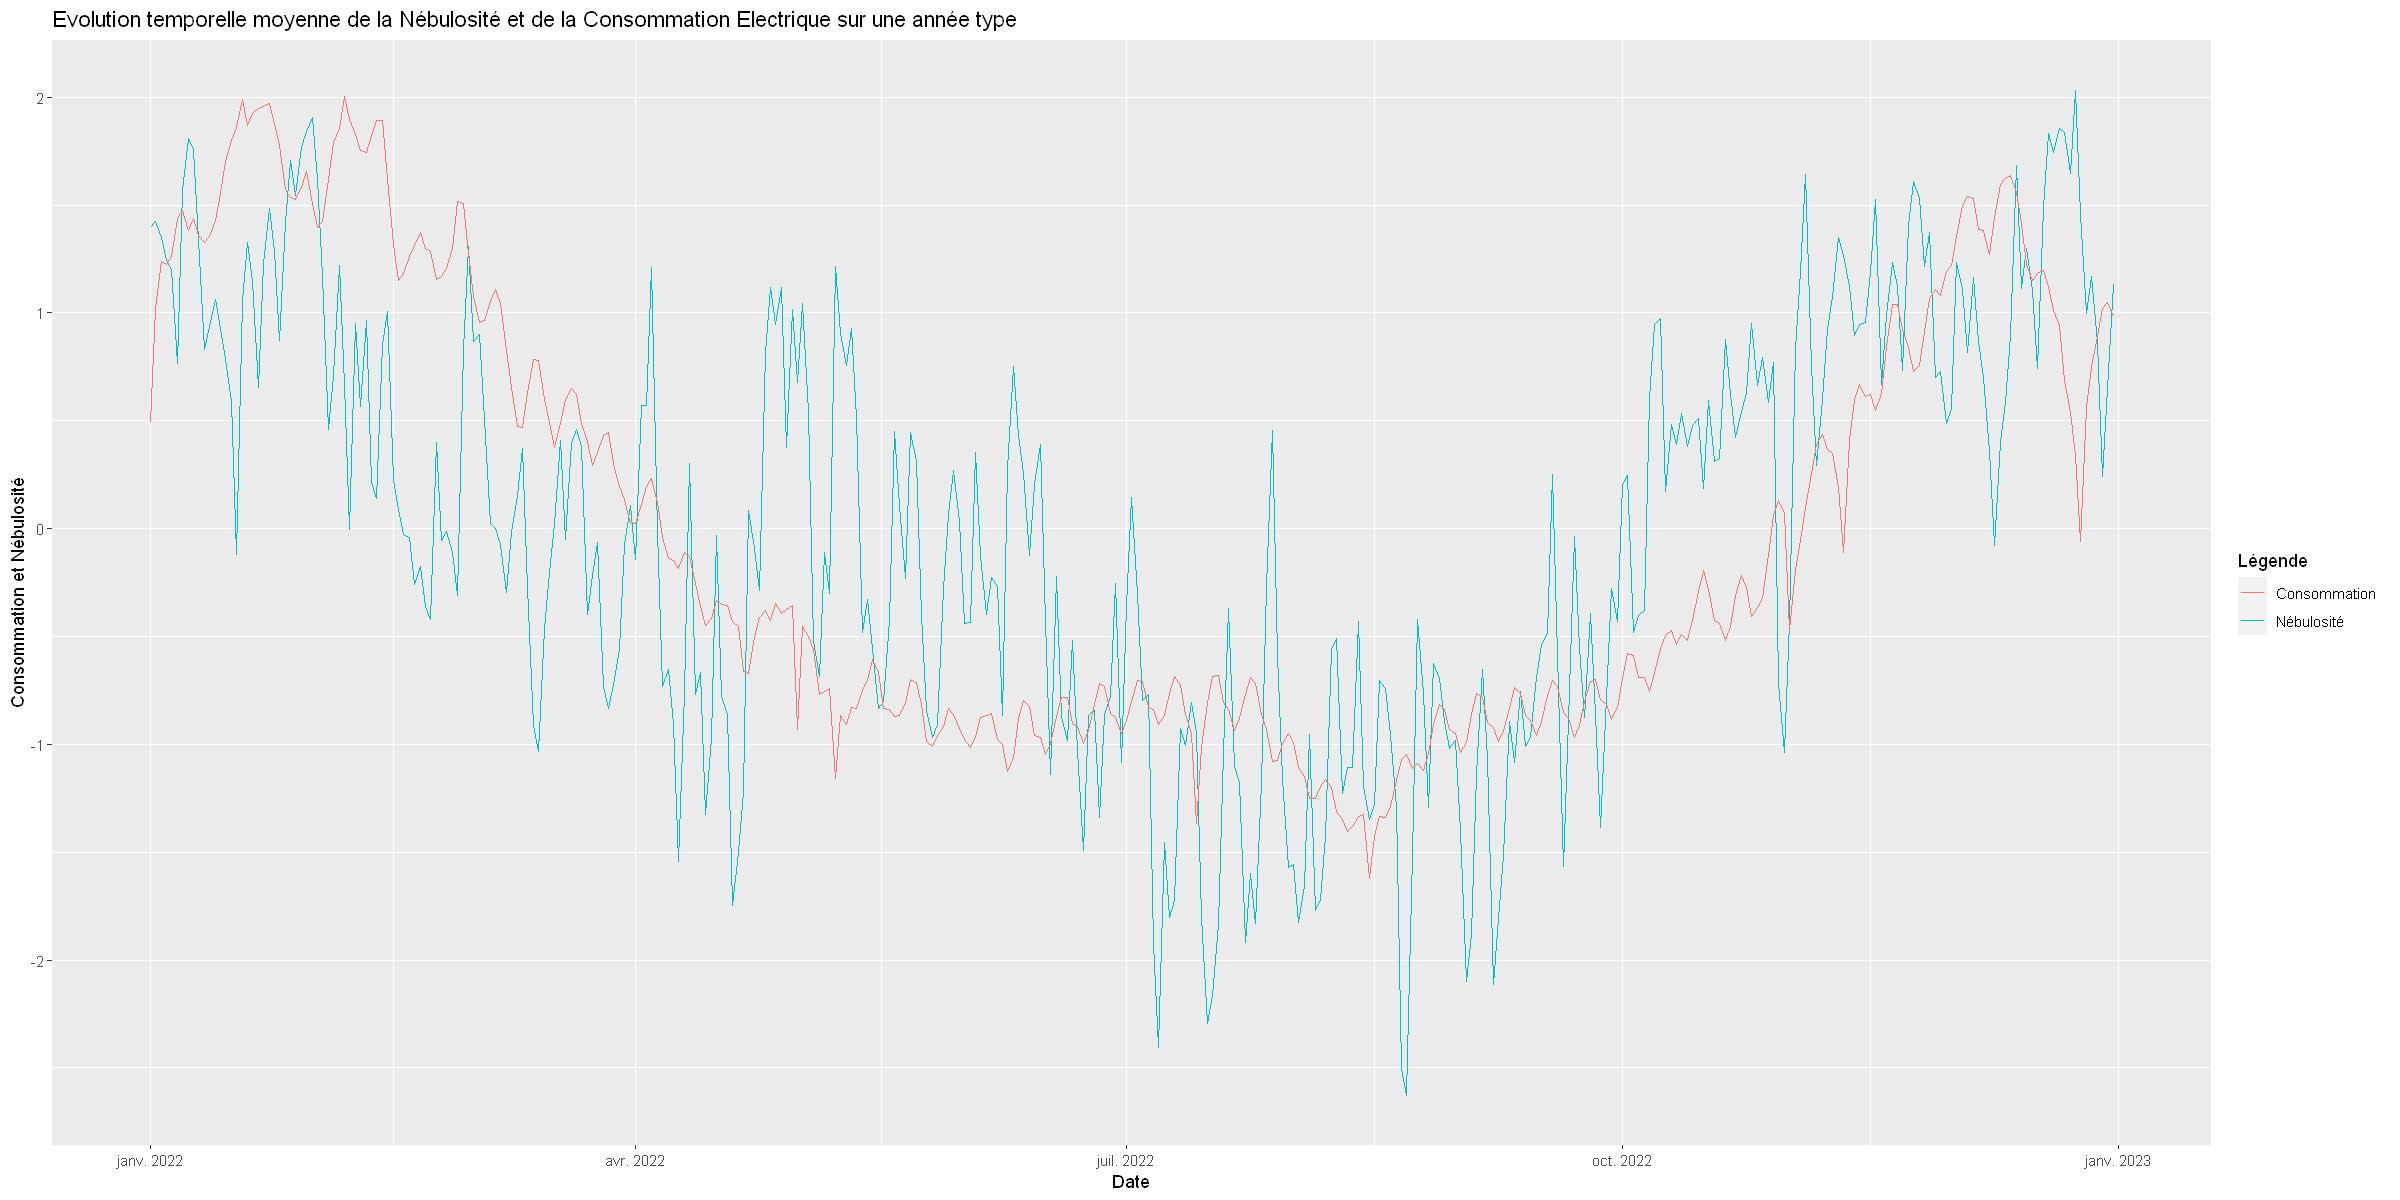

In [147]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_type_notime, aes(x=Date, y=Nebulosity_normalized, group = 1, color = 'Nébulosité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de la Nébulosité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Nébulosité")

La nébulosité et la consommation électrique semblent partager une même trajectoire temporelle

##### Etude de l'Humidité

`geom_smooth()` using formula 'y ~ x'



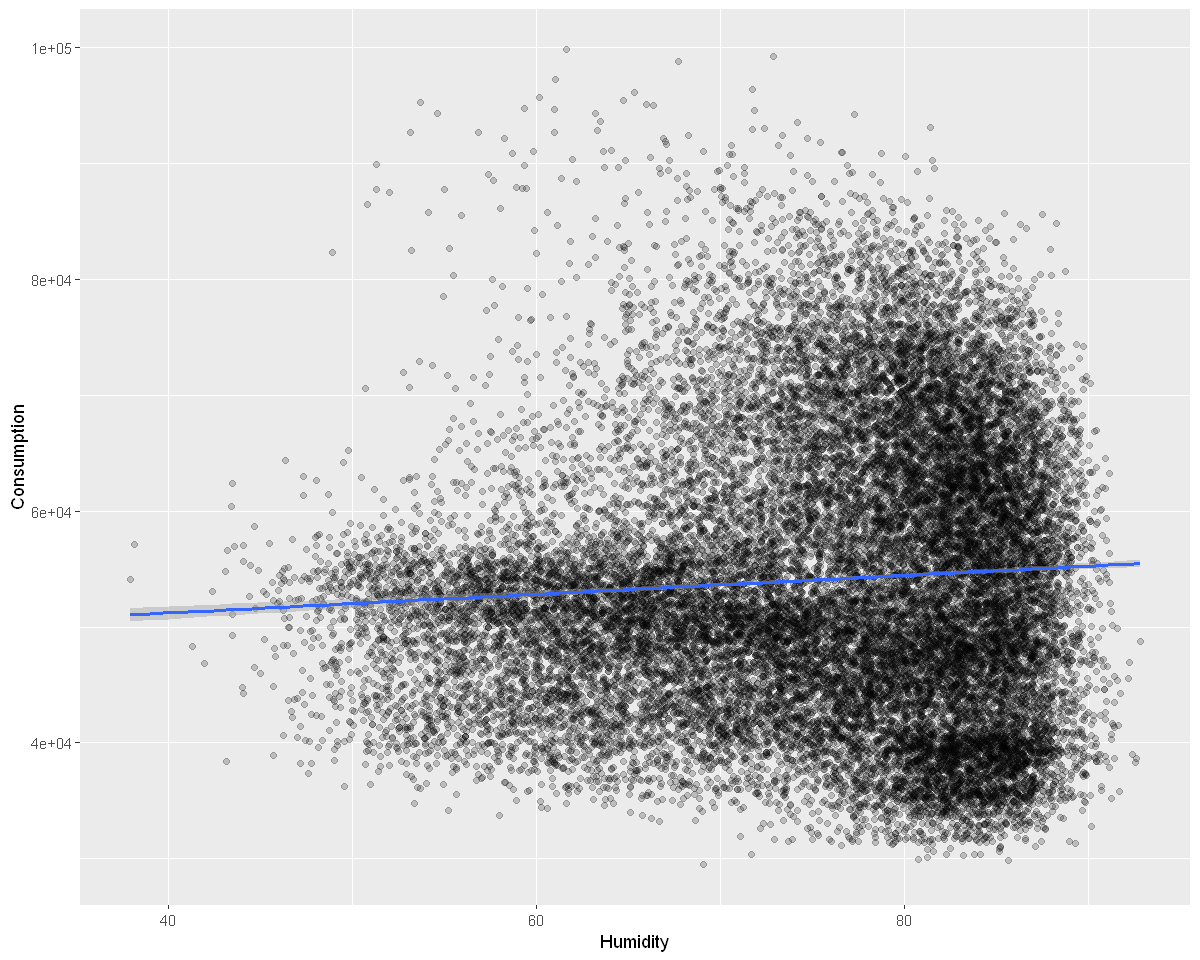

In [148]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data_train, aes(x = Humidity, y = Consumption)) +geom_point(alpha = 0.2) + geom_smooth(method = "lm")
#Très faible relation positive

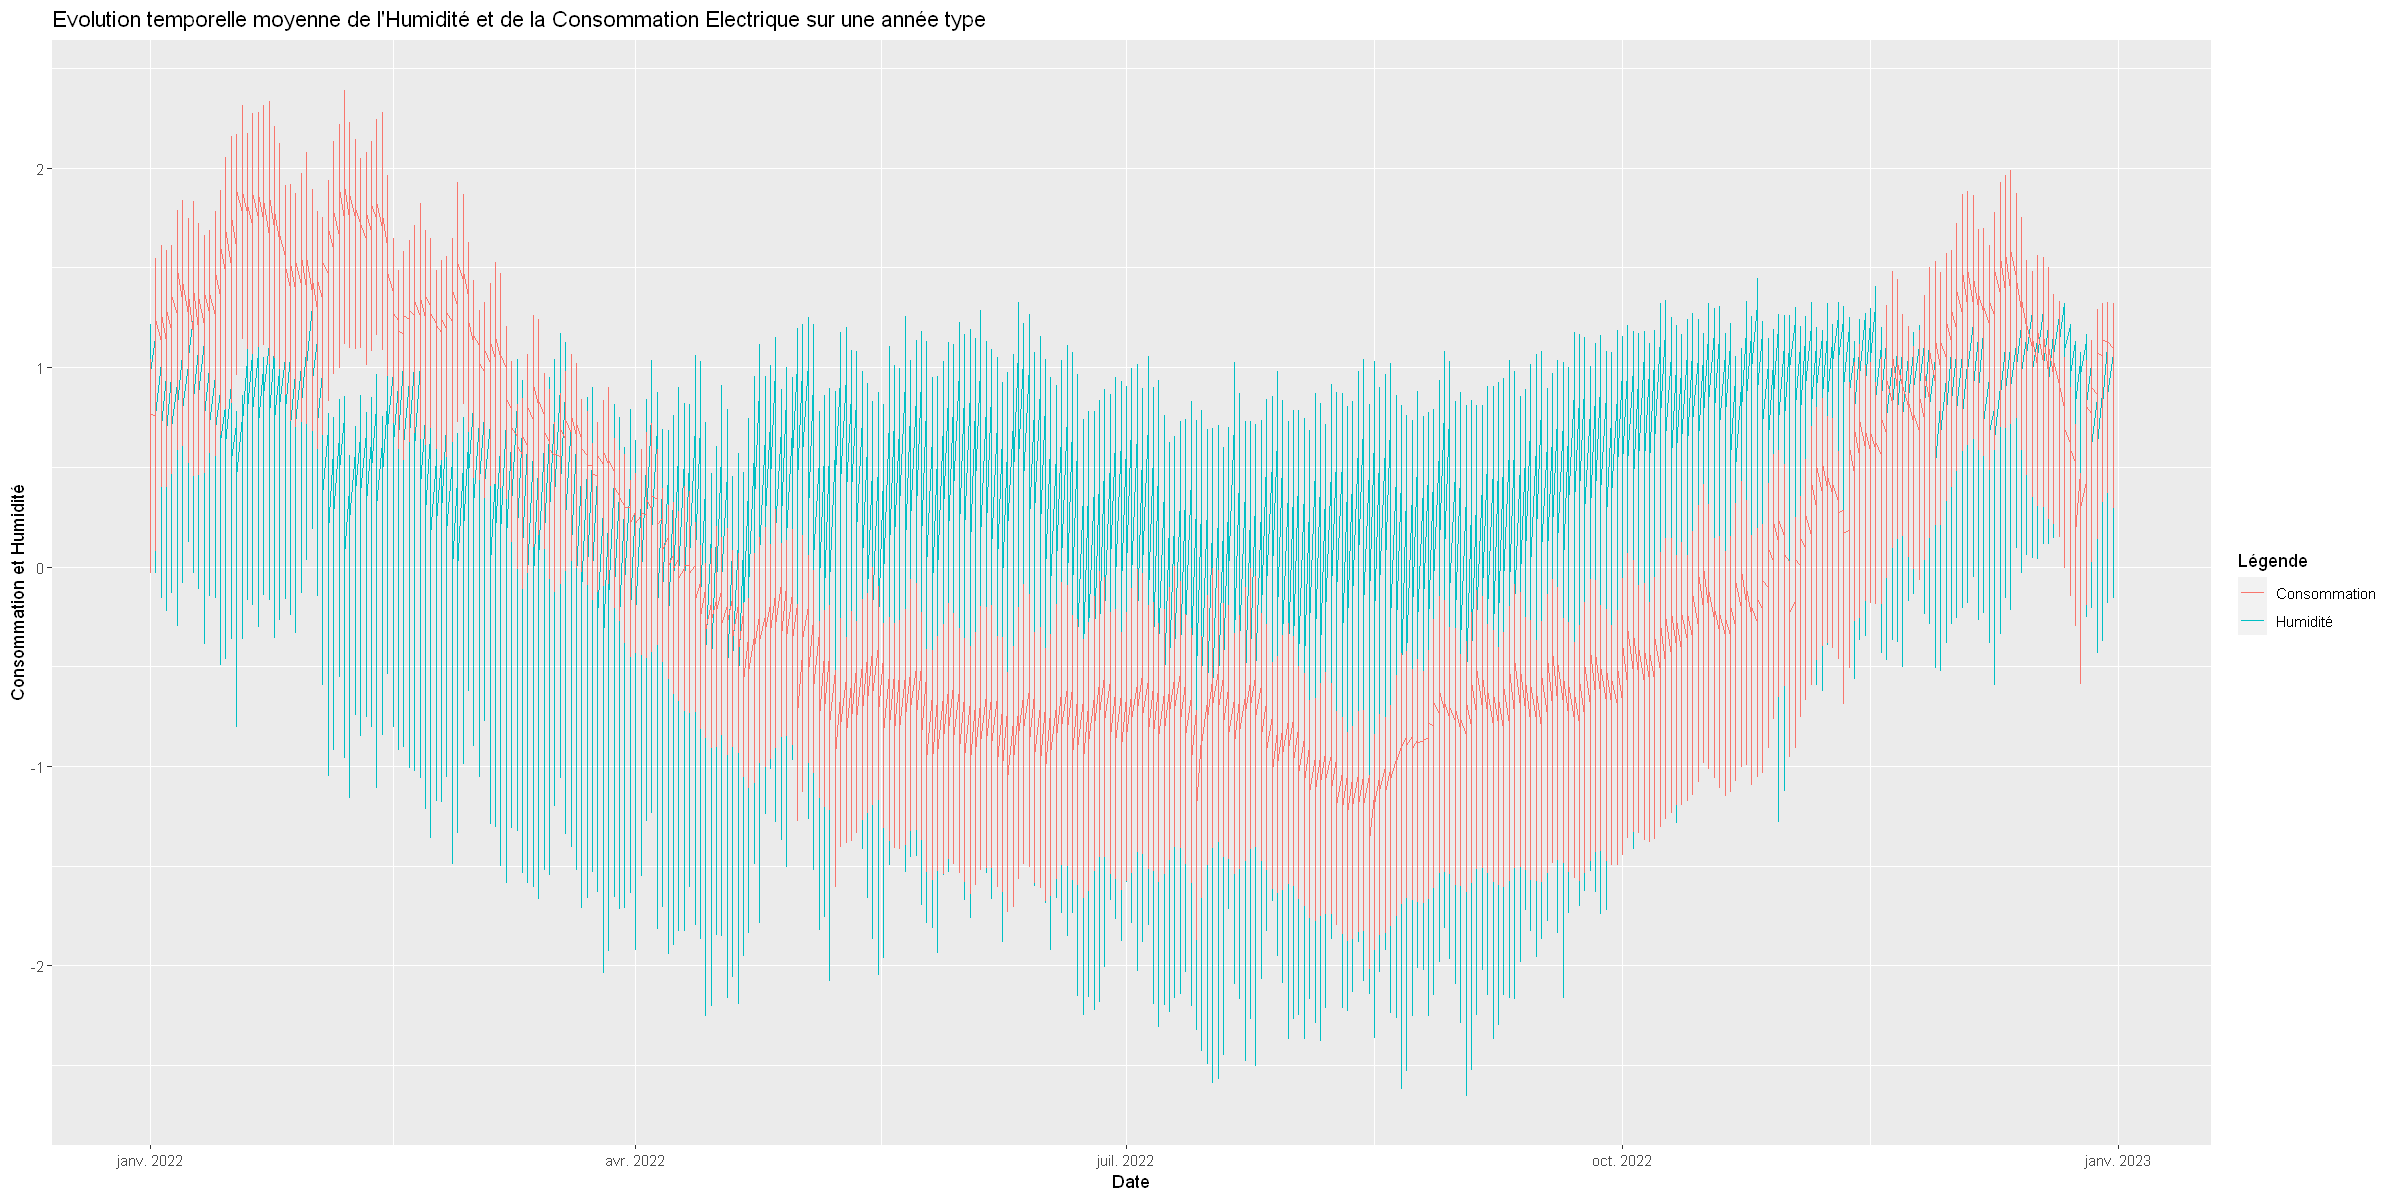

In [151]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_type, aes(x=Date, y=Humidity_normalized, group = 1, color = 'Humidité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de l'Humidité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Humidité")

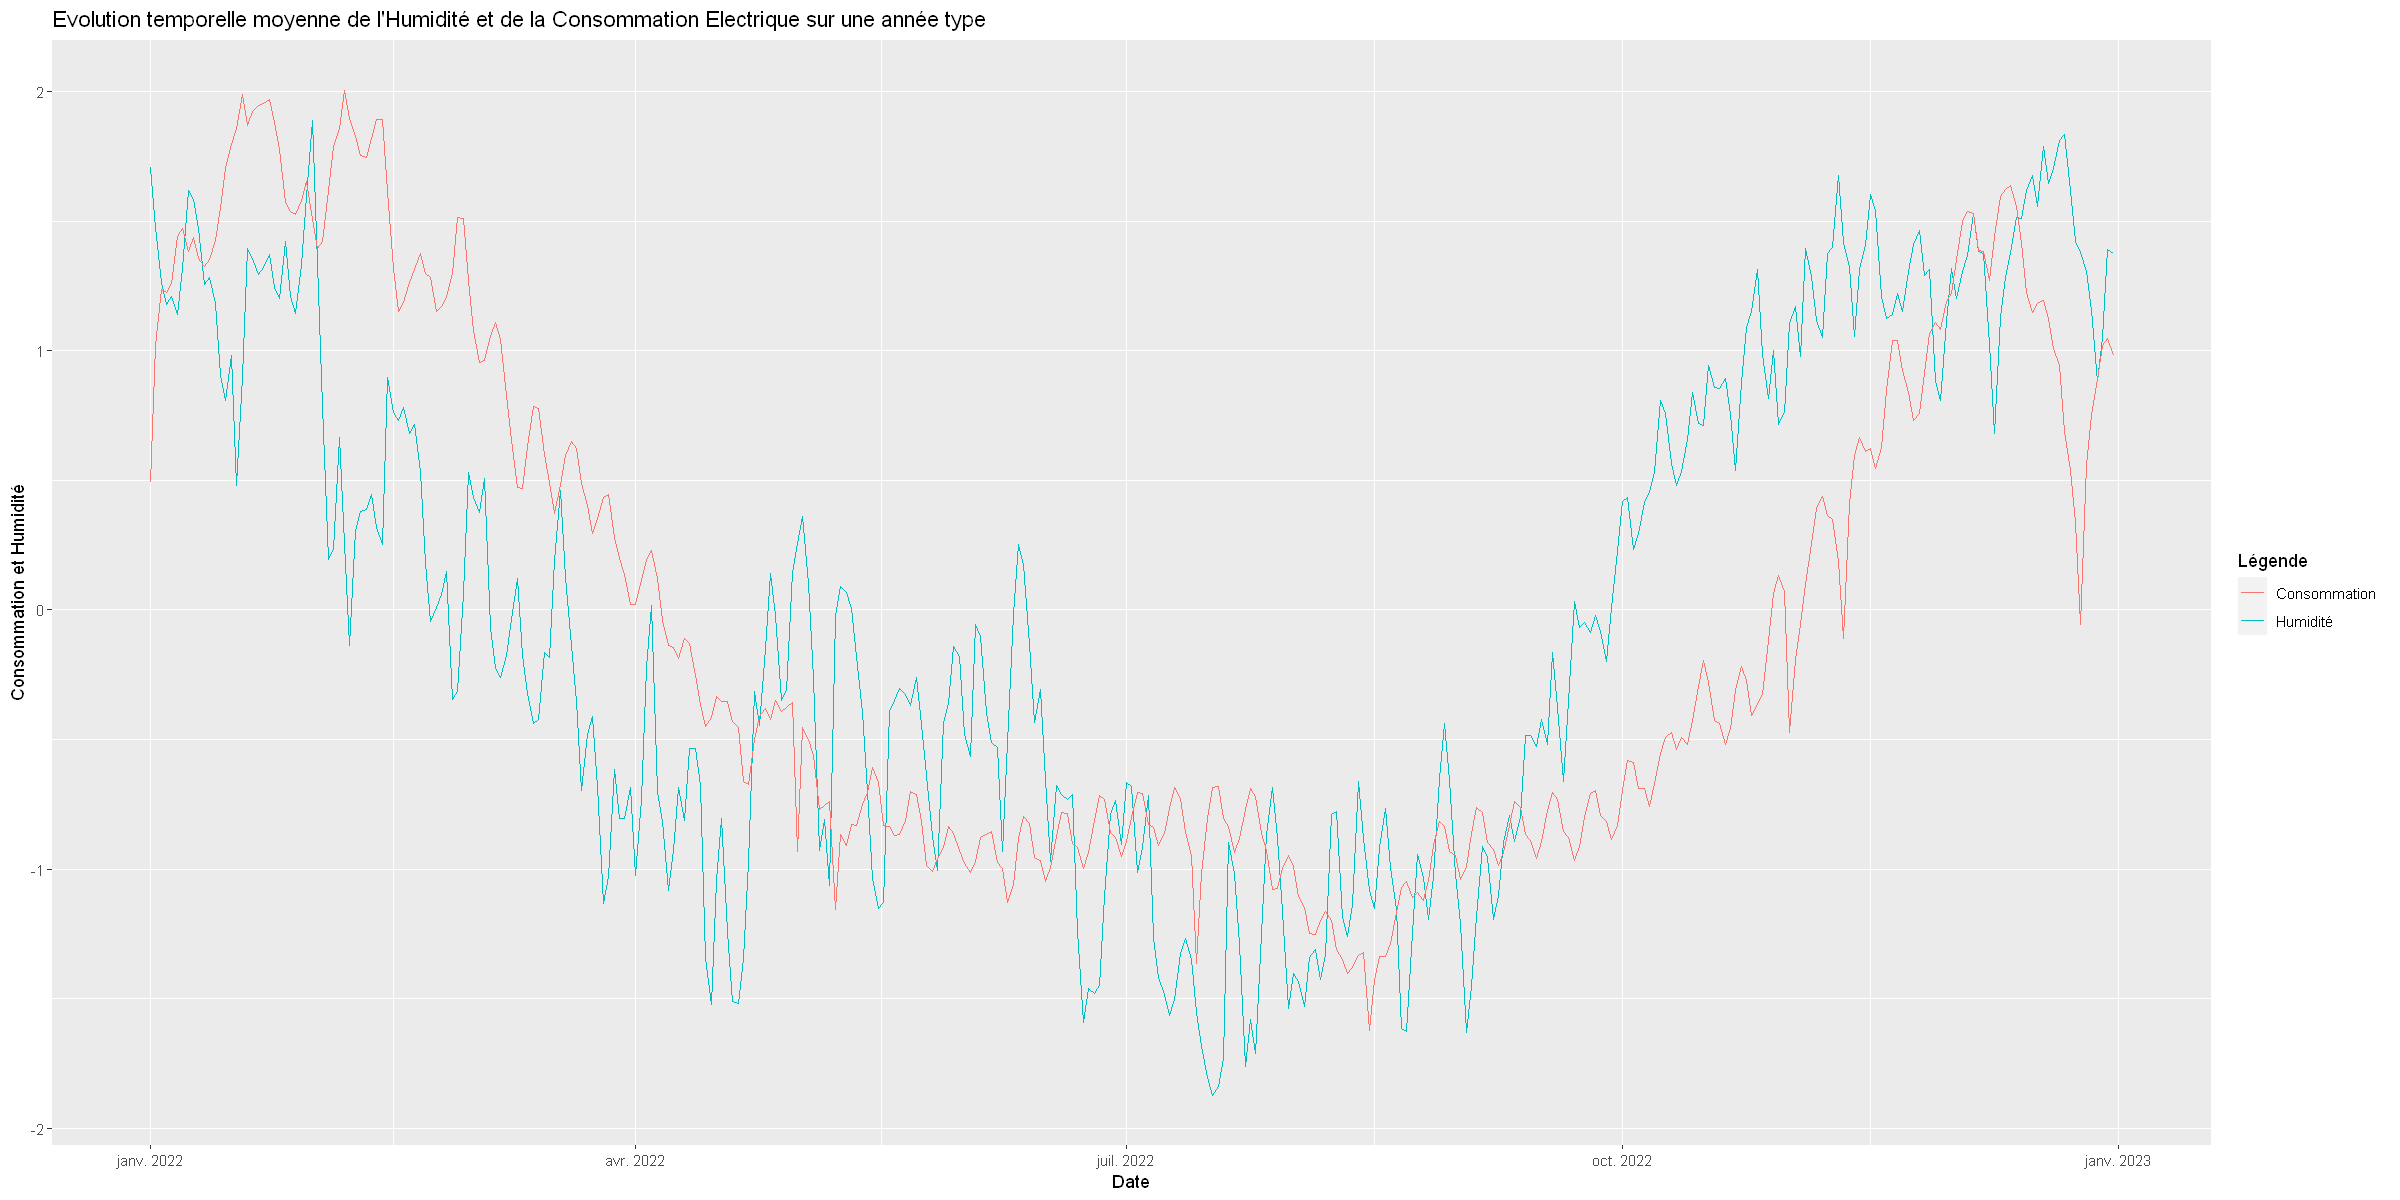

In [152]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_type_notime, aes(x=Date, y=Humidity_normalized, group = 1, color = 'Humidité')) + 
    geom_line() +
    geom_line(aes(x=Date, y=Consumption_normalized, colour = 'Consommation')) +
    labs(colour = "Légende") +
    labs(title = "Evolution temporelle moyenne de l'Humidité et de la Consommation Electrique sur une année type") +
    ylab("Consommation et Humidité")

L'humidité semble suivre la trajectoire temporelle de la consommation électrique, mais moins que la nébulosité

##### Etude de la saisonnalité annuelle

In [153]:
data_train_notime <- data_train %>%
   group_by(Date) %>% 
   summarise_at(vars("Consumption", "Temperature", "Nebulosity", "Humidity"), mean)

In [167]:
data_train_notime = data_train_notime %>% 
            separate(Date, c("Year", "Month", "Day"), sep = "-", remove = FALSE)

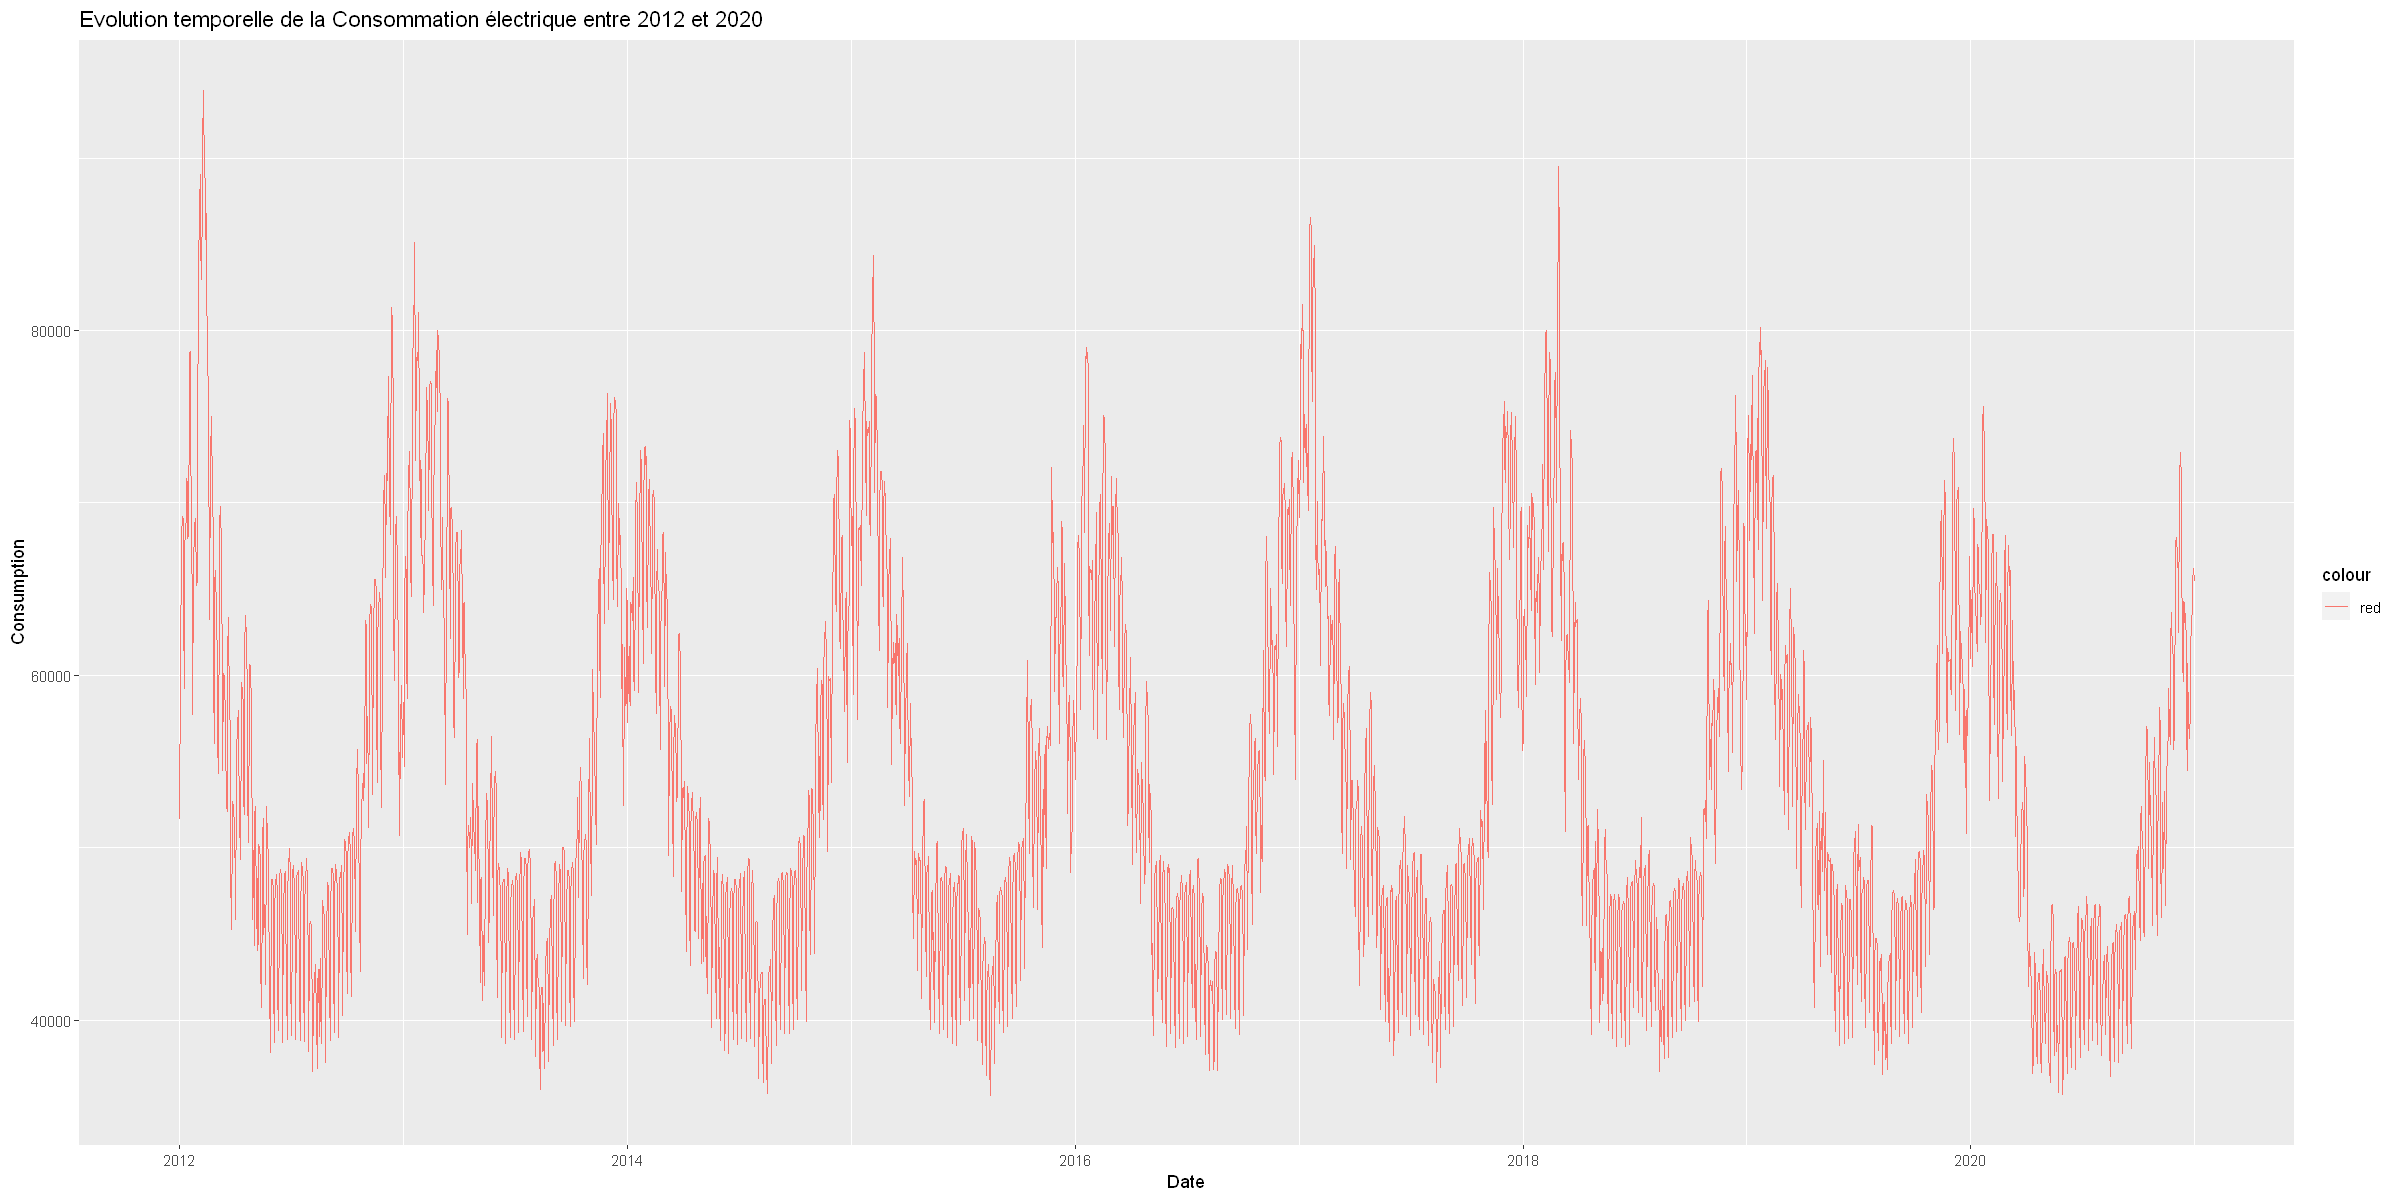

In [161]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_notime, aes(Date, Consumption, colour="Consommation électrique")) + geom_line() + ggtitle("Evolution temporelle de la Consommation électrique entre 2012 et 2020")

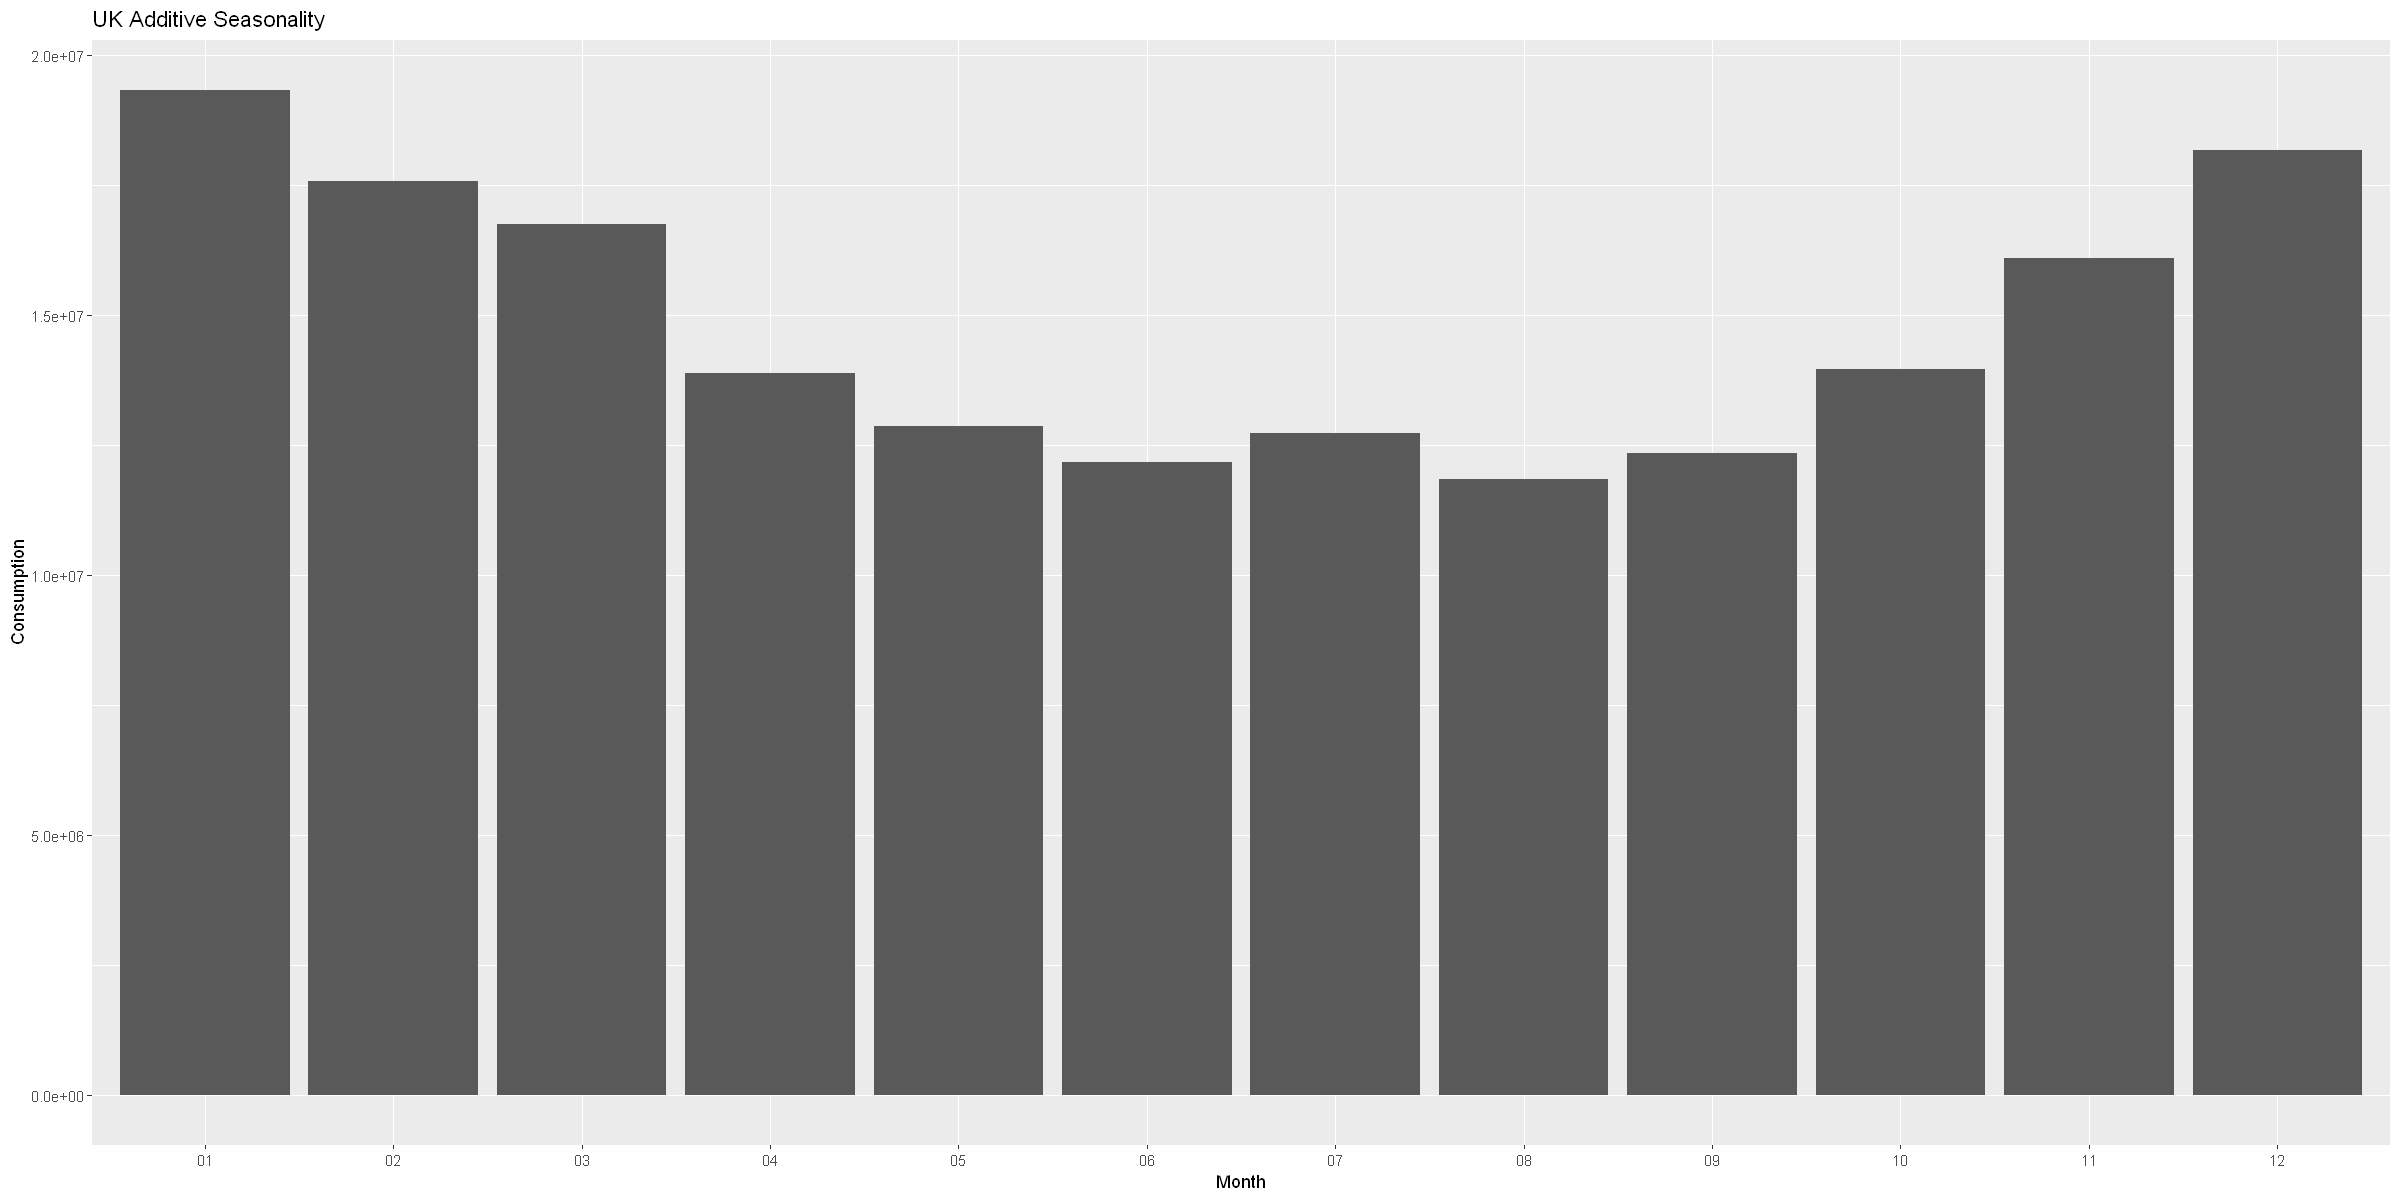

In [169]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data_train_notime,aes(Month,Consumption)) + geom_bar(stat = "identity") + ggtitle("UK Additive Seasonality")